# SOFIA/FORCAST Galactic Center Combine Fields Notebook

## Preliminary Steps - Select file to use from config.py and load in required packages

In [1]:
#import all required packages
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join, vstack, Table
from astropy.coordinates import SkyCoord, search_around_sky, Angle
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error
from photutils.morphology import data_properties
from photutils import make_source_mask

In [2]:
#new functions needed for this notebook
from astropy.coordinates.matching import _get_cartesian_kdtree

from regions import read_ds9, write_ds9, CircleSkyRegion

In [3]:
#import configuration for selected file
from config import dpath, dpathalt, ds9path #import additional common paramters

from config import *

In [4]:
from FORCASTphot import CombineFieldResults, remove_duplicates, createNames, findNOTindex, makeDS9reg, performApPhoto, fitshapes, modelSources

In [5]:
#change directory to where data is
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

## Combine data files for each field at 25 um

In [6]:
#create initial master catalog at 25 um
mastercat25=CombineFieldResults('CombCat',25)

#add names to mastercat
mastercat25=createNames(mastercat25)

#print the master catalog
mastercat25

finder,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [25,25]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17
6,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.4254323847296075,0.10047859268999702,3.901731543901466,0.20602930126570956,5.766012566152337,0.3138537723987596,842.388656766678,0.0008851762625907836,0.001385297292628078,0.008341885231348923,262.2360534667969,225.86353758410735,1.3788284820517576,0.12936110209918267,10.658756455202381,52.64929104791737,3.7153159331900665,0.2177933886787492,17.058901354761748,210.5971641916695,5.3465774420516885,0.3219711054998841,16.605767880166542,473.84361943125634,Field52,25,6.773246447790066,7.90006063970864,6.658779818128786,3.305867543276211,2.2501731923563724,-79.35223562495774,1.4691613758913906,5.263528165472576,10.728511443813781,4.430459560064134,8.267492190760558,12.42237717084893,1.546021859449711,2.564374869568375,0.03633240450218003,18.75188986811762,7920.250407765045,7.452160358060758,4106.961128272308,8.992592502509412,6.892220167395375,15.968698774952788,2.3169165213982836,0.0843664586075464,4.1639941103629505,0.17965836021277484,52.78562416781967,0.4798722526249289,4.190513551643066,0.17671019756606518,51.496730503483676,0.3872041232168606,0,-0.02055534524879702 .. 0.0036593754890893483,1.3824369896859543,1.1154745863422288,M,266.09497709302605,-29.53686745240035,359.3464408339575,-0.0829354059850822,1,"266.09497709302605,-29.53686745240035",SFGC359.346-0.083
6,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",1.883544002948578,0.08565943133236655,4.5923102290210975,0.17996353881007984,6.48560913974104,0.2839276380664405,842.388656766678,0.0002328104769597328,0.000520432385364129,0.007133331433204576,297.2008361816406,298.83307560920025,1.8712866963881203,0.10843001936094702,17.258013116818617,52.64929104791737,4.543281002779268,0.19062230322287788,23.833942439921152,210.5971641916695,6.375293380696923,0.2910435038528583,21.90494993463264,473.84361943125634,Field52,25,6.71429840320007,5.4837693317692935,5.978782386232811,2.873531482061738,2.1529985884349516,-83.07794267248534,1.3346648239795424,4.688008674832299,8.204577425370523,1.0241201094505705,7.180857891373572,7.38532268265691,0.7250985713771495,0.7176812073671344,0.04089458074398592,46.38075871020914,1115423.2510418692,45.15065978746032,4085412.496445785,8.860917338717407,2.1258836429851897e-38,2.1258836429851897e-38,1.0,0.0012396364352219148,5.172204456871925,0.18084515336

In [7]:
#Optional - write 'master' catalogs to fits prior to quality cuts
#mastercat25.write('masterCatComb_FromFields_25um_NoCuts.fits',overwrite=True)

In [8]:
#write out save ds9 region files  - Optional for inspection
#set size of regions 
r = Angle(2.778E-4*3, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9reg('mastercatComb_25um_labelID.reg', mastercat25, r, color='yellow', label="id")
makeDS9reg('mastercatComb_25um_label4pixSNR.reg', mastercat25, r, color='cyan', label="aper_snr_4pix");
makeDS9reg('mastercatComb_25um_label8pixSNR.reg', mastercat25, 3*r, color='green', label="aper_snr_8pix");

In [9]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included: ', len(mastercat25))
mastercat25,nduplicats=remove_duplicates(mastercat25, 3.0*u.arcsec)
print('Number of sources with duplicates removed: ', len(mastercat25))

Number of sources with duplicates included:  1105
number of likely duplicates:  290
Number of sources with duplicates removed:  960


In [10]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included: ', len(mastercat25))
mastercat25,nduplicates=remove_duplicates(mastercat25, 3.0*u.arcsec)
print('Number of sources with duplicates removed: ', len(mastercat25))

Number of sources with duplicates included:  960
number of likely duplicates:  14
Number of sources with duplicates removed:  953


In [11]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included: ', len(mastercat25))
mastercat25,nduplicates=remove_duplicates(mastercat25, 3.0*u.arcsec)
print('Number of sources with duplicates removed: ', len(mastercat25))

Number of sources with duplicates included:  953
number of likely duplicates:  0
Number of sources with duplicates removed:  953


In [12]:
#write out save ds9 region files - optional for testing
makeDS9reg('mastercat_noDuplicates_25um_labelID.reg', mastercat25, r, color='magenta', label="id");

In [13]:
mastercat25

finder,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [25,25]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17,int64
6,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.4254323847296075,0.10047859268999702,3.901731543901466,0.20602930126570956,5.766012566152337,0.3138537723987596,842.388656766678,0.0008851762625907836,0.001385297292628078,0.008341885231348923,262.2360534667969,225.86353758410735,1.3788284820517576,0.12936110209918267,10.658756455202381,52.64929104791737,3.7153159331900665,0.2177933886787492,17.058901354761748,210.5971641916695,5.3465774420516885,0.3219711054998841,16.605767880166542,473.84361943125634,Field52,25,6.773246447790066,7.90006063970864,6.658779818128786,3.305867543276211,2.2501731923563724,-79.35223562495774,1.4691613758913906,5.263528165472576,10.728511443813781,4.430459560064134,8.267492190760558,12.42237717084893,1.546021859449711,2.564374869568375,0.03633240450218003,18.75188986811762,7920.250407765045,7.452160358060758,4106.961128272308,8.992592502509412,6.892220167395375,15.968698774952788,2.3169165213982836,0.0843664586075464,4.1639941103629505,0.17965836021277484,52.78562416781967,0.4798722526249289,4.190513551643066,0.17671019756606518,51.496730503483676,0.3872041232168606,0,-0.02055534524879702 .. 0.0036593754890893483,1.3824369896859543,1.1154745863422288,M,266.09497709302605,-29.53686745240035,359.3464408339575,-0.0829354059850822,1,"266.09497709302605,-29.53686745240035",SFGC359.346-0.083,0
6,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",1.883544002948578,0.08565943133236655,4.5923102290210975,0.17996353881007984,6.48560913974104,0.2839276380664405,842.388656766678,0.0002328104769597328,0.000520432385364129,0.007133331433204576,297.2008361816406,298.83307560920025,1.8712866963881203,0.10843001936094702,17.258013116818617,52.64929104791737,4.543281002779268,0.19062230322287788,23.833942439921152,210.5971641916695,6.375293380696923,0.2910435038528583,21.90494993463264,473.84361943125634,Field52,25,6.71429840320007,5.4837693317692935,5.978782386232811,2.873531482061738,2.1529985884349516,-83.07794267248534,1.3346648239795424,4.688008674832299,8.204577425370523,1.0241201094505705,7.180857891373572,7.38532268265691,0.7250985713771495,0.7176812073671344,0.04089458074398592,46.38075871020914,1115423.2510418692,45.15065978746032,4085412.496445785,8.860917338717407,2.1258836429851897e-38,2.1258836429851897e-38,1.0,0.0012396364352219148,5.172204456

### Quality flags and other cuts

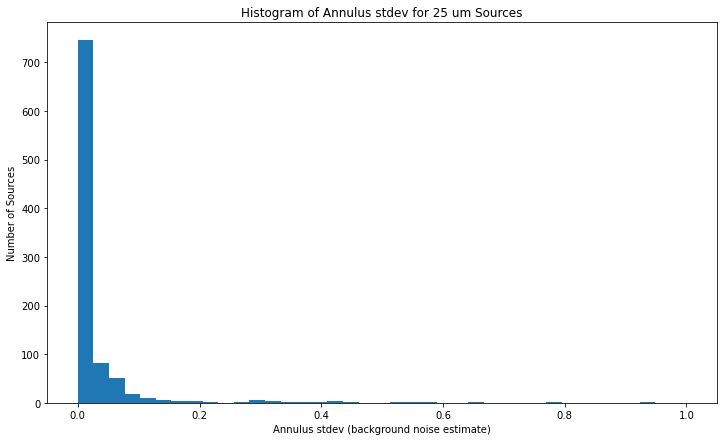

In [14]:
#now lets look at some quality flags...
binlist=np.linspace(0,1.0,40)

plt.figure(figsize=(12,7))
plt.title('Histogram of Annulus stdev for 25 um Sources')
plt.hist(mastercat25['ann_bkg_std'],bins=binlist)
plt.xlabel('Annulus stdev (background noise estimate)')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()

In [15]:
#add quality flags for background noise
bkgmean=np.mean(mastercat25['ann_bkg_std'])
bkgstd=np.std(mastercat25['ann_bkg_std'])

print("average noise measurement for all sources: ", bkgmean, ", standard deviation of noise measurements: ", bkgstd)

bkgstd1sig=mastercat25['ann_bkg_std']>bkgmean+bkgstd
bkgstd2sig=mastercat25['ann_bkg_std']>bkgmean+2*bkgstd
bkgstd3sig=mastercat25['ann_bkg_std']>bkgmean+3*bkgstd


mastercat25['bkg_qflag']=0
mastercat25['bkg_qflag'][bkgstd1sig]=1
mastercat25['bkg_qflag'][bkgstd2sig]=2
mastercat25['bkg_qflag'][bkgstd3sig]=3

average noise measurement for all sources:  0.03674008454097723 , standard deviation of noise measurements:  0.1197032465187423


In [16]:
#check if there are masked elements before applying cut - if false - don't worry, if true - investigate masked values
np.ma.getmask(mastercat25['aper_snr_4pix'])

False

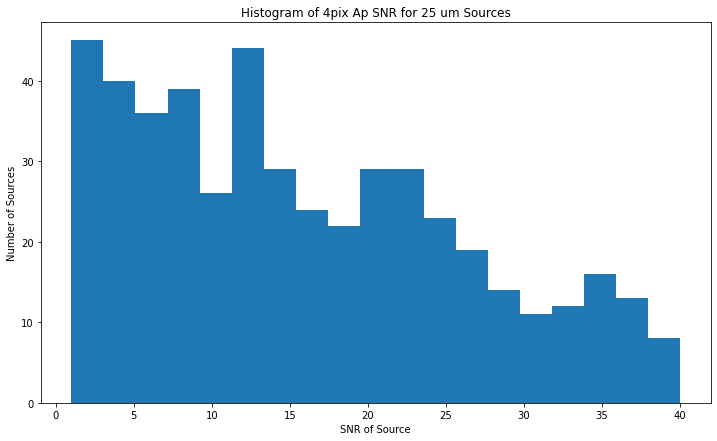

In [17]:
#now lets look at SNR distrobution
binlist=np.linspace(1,40,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of 4pix Ap SNR for 25 um Sources')
plt.hist(mastercat25['aper_snr_4pix'],bins=binlist)
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()


In [18]:
#lets examine SNR cuts...
snrcut4pix=mastercat25['aper_snr_4pix']>=0.5 #max snr in all computed apertures must be gtreq to 5
mcat25snrcut=mastercat25[snrcut4pix] #apply snr cut

#snrcutModel=mastercat25['ModelSNR']>=1.0 #max snr in all computed apertures must be gtreq to 5
#mcat25snrcut=mastercat25[snrcutModel] #apply snr cut


print("Number of Catalog Sources after SNR cut: ", len(mcat25snrcut))

Number of Catalog Sources after SNR cut:  761


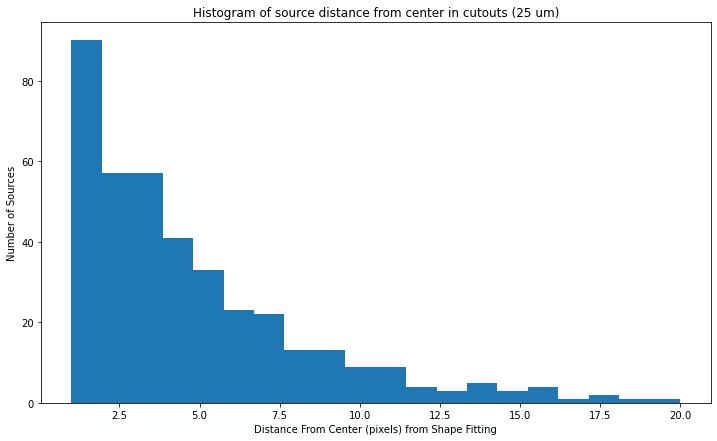

In [19]:
binlist=np.linspace(1,20,21)

plt.figure(figsize=(12,7))
plt.title('Histogram of source distance from center in cutouts (25 um)')
plt.hist(mcat25snrcut['fit_dist'],bins=binlist)
plt.xlabel('Distance From Center (pixels) from Shape Fitting')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()

In [20]:
print('Central distance fit mean: ', np.mean(mcat25snrcut['fit_dist']), '  stdev: ',np.std(mcat25snrcut['fit_dist']))

Central distance fit mean:  4.120953972318991   stdev:  12.926526153059053


In [21]:
sigma_clipped_stats(mcat25snrcut['fit_dist'],sigma=3)

(1.7295857424006524, 0.8622885256282391, 1.7030080746237568)

In [22]:
#apply quality flags to table
Distmean=np.mean(mcat25snrcut['fit_dist'])
Diststd=np.std(mcat25snrcut['fit_dist'])

distidx1=mcat25snrcut['fit_dist']>4.0
distidx2=mcat25snrcut['fit_dist']>7.0

mcat25snrcut['shape_qflag']=0

mcat25snrcut['shape_qflag'][distidx1]=10
mcat25snrcut['shape_qflag'][distidx2]=mcat25snrcut['shape_qflag'][distidx2]+10

In [23]:
#note this really isn't used for flagging anymore - 8/31/22
#old - I think these come from shape fitting parameters which is depreciated. 


'''
binlist=np.linspace(0,40,40)

plt.figure(figsize=(12,7))
plt.title('Shape Parameters fit Errors')
plt.hist(mcat25snrcut['covar_sigx2'],bins=binlist,label=r'$\sigma_x^2$')
plt.hist(mcat25snrcut['covar_sigy2'],bins=binlist,label=r'$\sigma_y^2$')
plt.xlabel('Error functions from shape fitting')
plt.ylabel('Number of Sources')
plt.legend()
plt.show()
'''

"\nbinlist=np.linspace(0,40,40)\n\nplt.figure(figsize=(12,7))\nplt.title('Shape Parameters fit Errors')\nplt.hist(mcat25snrcut['covar_sigx2'],bins=binlist,label=r'$\\sigma_x^2$')\nplt.hist(mcat25snrcut['covar_sigy2'],bins=binlist,label=r'$\\sigma_y^2$')\nplt.xlabel('Error functions from shape fitting')\nplt.ylabel('Number of Sources')\nplt.legend()\nplt.show()\n"

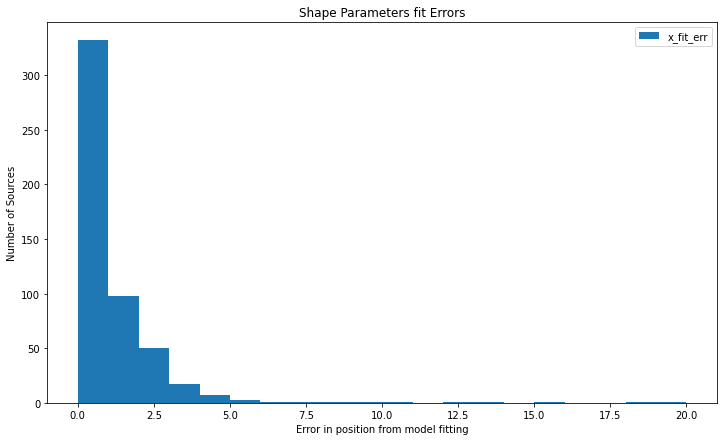

In [24]:
#note this really isn't used for flagging anymore - 8/31/22
#think if this should be implemented again but differently...

binlist=np.linspace(0,20,21)
#binlist=np.linspace(0,50,51)

plt.figure(figsize=(12,7))
plt.title('Shape Parameters fit Errors')
plt.hist(mastercat25['fit_x0_err'],bins=binlist,label=r'x_fit_err')
#plt.hist(mastercat25['fit_y0_err'],bins=binlist,label=r'y_fit_err')
#plt.hist(np.sqrt(mastercat25['fit_y0_err']**2+mastercat25['fit_x0_err']**2),bins=binlist,label=r'posfiterr')
#plt.hist(mastercat25['fit_gamma_err'],bins=binlist)
plt.xlabel('Error in position from model fitting')
plt.ylabel('Number of Sources')
plt.legend()
plt.show()#fit_gamma_err


In [25]:
#print('Covar X^2 mean: ', np.mean(mcat25snrcut['covar_sigx2']), '  stdev: ',np.std(mcat25snrcut['covar_sigx2']))
#print('Covar Y^2 mean: ', np.mean(mcat25snrcut['covar_sigy2']), '  stdev: ',np.std(mcat25snrcut['covar_sigy2']))

In [26]:
#add quality flags to table
#sigXmean=np.mean(mcat25snrcut['covar_sigx2'])
#sigXstd=np.std(mcat25snrcut['covar_sigx2'])

#sigYmean=np.mean(mcat25snrcut['covar_sigy2'])
#sigYstd=np.std(mcat25snrcut['covar_sigy2'])

#sigXidx=mcat25snrcut['covar_sigx2']>sigXmean+2*sigXstd
#sigYidx=mcat25snrcut['covar_sigy2']>sigYmean+2*sigYstd

#mcat25snrcut['shape_qflag'][sigXidx]=mcat25snrcut['shape_qflag'][sigXidx]+1
#mcat25snrcut['shape_qflag'][sigYidx]=mcat25snrcut['shape_qflag'][sigYidx]+1

In [27]:
#number of sources that are well fit by shape fitting
#np.count_nonzero(mcat25snrcut['shape_qflag']==0)

In [28]:
#number of sources that may not be well fit by the shape fitting
#np.count_nonzero(mcat25snrcut['shape_qflag']>0)

In [29]:
mcat25snrcut

finder,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [25,25]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch,bkg_qflag,shape_qflag
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17,int64,int32,int32
6,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.4254323847296075,0.10047859268999702,3.901731543901466,0.20602930126570956,5.766012566152337,0.3138537723987596,842.388656766678,0.0008851762625907836,0.001385297292628078,0.008341885231348923,262.2360534667969,225.86353758410735,1.3788284820517576,0.12936110209918267,10.658756455202381,52.64929104791737,3.7153159331900665,0.2177933886787492,17.058901354761748,210.5971641916695,5.3465774420516885,0.3219711054998841,16.605767880166542,473.84361943125634,Field52,25,6.773246447790066,7.90006063970864,6.658779818128786,3.305867543276211,2.2501731923563724,-79.35223562495774,1.4691613758913906,5.263528165472576,10.728511443813781,4.430459560064134,8.267492190760558,12.42237717084893,1.546021859449711,2.564374869568375,0.03633240450218003,18.75188986811762,7920.250407765045,7.452160358060758,4106.961128272308,8.992592502509412,6.892220167395375,15.968698774952788,2.3169165213982836,0.0843664586075464,4.1639941103629505,0.17965836021277484,52.78562416781967,0.4798722526249289,4.190513551643066,0.17671019756606518,51.496730503483676,0.3872041232168606,0,-0.02055534524879702 .. 0.0036593754890893483,1.3824369896859543,1.1154745863422288,M,266.09497709302605,-29.53686745240035,359.3464408339575,-0.0829354059850822,1,"266.09497709302605,-29.53686745240035",SFGC359.346-0.083,0,0,10
6,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",1.883544002948578,0.08565943133236655,4.5923102290210975,0.17996353881007984,6.48560913974104,0.2839276380664405,842.388656766678,0.0002328104769597328,0.000520432385364129,0.007133331433204576,297.2008361816406,298.83307560920025,1.8712866963881203,0.10843001936094702,17.258013116818617,52.64929104791737,4.543281002779268,0.19062230322287788,23.833942439921152,210.5971641916695,6.375293380696923,0.2910435038528583,21.90494993463264,473.84361943125634,Field52,25,6.71429840320007,5.4837693317692935,5.978782386232811,2.873531482061738,2.1529985884349516,-83.07794267248534,1.3346648239795424,4.688008674832299,8.204577425370523,1.0241201094505705,7.180857891373572,7.38532268265691,0.7250985713771495,0.7176812073671344,0.04089458074398592,46.38075871020914,1115423.2510418692,45.15065978746032,4085412.496445785,8.860917338717407,2.1258836429851897e-38,2.1258836429851897e

In [30]:
#makeDS9reg('mastercatComb_4pixSNRselect_25m_NoLabel.reg', mcat25snrcut, r, color='green');

In [31]:
#check if there are masked elements before applying cut
np.ma.is_masked(mastercat25['fit_fwhm'])

True

In [32]:
#write out save ds9 region files - optional for testing
#makeDS9reg('mastercat_25um_modelSNR.reg', mastercat25, 2.2*r, color='red', label="ModelSNR");

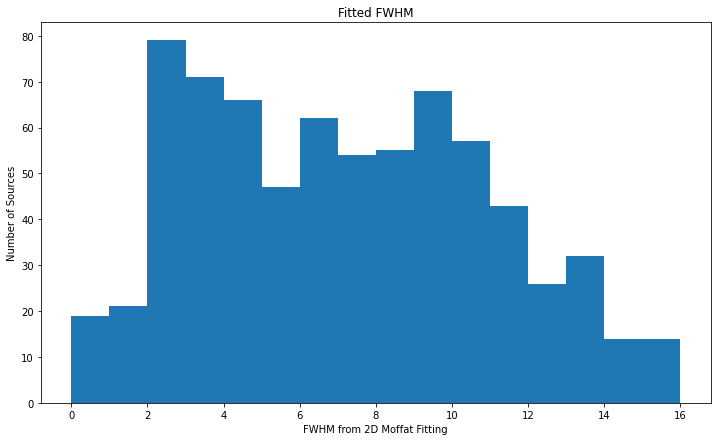

In [33]:
binlist=np.linspace(0,16,17)

plt.figure(figsize=(12,7))
plt.title('Fitted FWHM')
plt.hist(mcat25snrcut['fit_fwhm'],bins=binlist)
plt.xlabel('FWHM from 2D Moffat Fitting')
plt.ylabel('Number of Sources')
plt.show()

In [34]:
# real sources have FWHM that are at least a couple of pixels - note this also eliminates masked sources
update25=mcat25snrcut[mcat25snrcut['fit_fwhm']>=1.0]

In [35]:
update25

finder,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [25,25]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch,bkg_qflag,shape_qflag
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17,int64,int32,int32
6,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.4254323847296075,0.10047859268999702,3.901731543901466,0.20602930126570956,5.766012566152337,0.3138537723987596,842.388656766678,0.0008851762625907836,0.001385297292628078,0.008341885231348923,262.2360534667969,225.86353758410735,1.3788284820517576,0.12936110209918267,10.658756455202381,52.64929104791737,3.7153159331900665,0.2177933886787492,17.058901354761748,210.5971641916695,5.3465774420516885,0.3219711054998841,16.605767880166542,473.84361943125634,Field52,25,6.773246447790066,7.90006063970864,6.658779818128786,3.305867543276211,2.2501731923563724,-79.35223562495774,1.4691613758913906,5.263528165472576,10.728511443813781,4.430459560064134,8.267492190760558,12.42237717084893,1.546021859449711,2.564374869568375,0.03633240450218003,18.75188986811762,7920.250407765045,7.452160358060758,4106.961128272308,8.992592502509412,6.892220167395375,15.968698774952788,2.3169165213982836,0.0843664586075464,4.1639941103629505,0.17965836021277484,52.78562416781967,0.4798722526249289,4.190513551643066,0.17671019756606518,51.496730503483676,0.3872041232168606,0,-0.02055534524879702 .. 0.0036593754890893483,1.3824369896859543,1.1154745863422288,M,266.09497709302605,-29.53686745240035,359.3464408339575,-0.0829354059850822,1,"266.09497709302605,-29.53686745240035",SFGC359.346-0.083,0,0,10
6,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",1.883544002948578,0.08565943133236655,4.5923102290210975,0.17996353881007984,6.48560913974104,0.2839276380664405,842.388656766678,0.0002328104769597328,0.000520432385364129,0.007133331433204576,297.2008361816406,298.83307560920025,1.8712866963881203,0.10843001936094702,17.258013116818617,52.64929104791737,4.543281002779268,0.19062230322287788,23.833942439921152,210.5971641916695,6.375293380696923,0.2910435038528583,21.90494993463264,473.84361943125634,Field52,25,6.71429840320007,5.4837693317692935,5.978782386232811,2.873531482061738,2.1529985884349516,-83.07794267248534,1.3346648239795424,4.688008674832299,8.204577425370523,1.0241201094505705,7.180857891373572,7.38532268265691,0.7250985713771495,0.7176812073671344,0.04089458074398592,46.38075871020914,1115423.2510418692,45.15065978746032,4085412.496445785,8.860917338717407,2.1258836429851897e-38,2.1258836429851897e

In [36]:
#Optional - write 'master' catalogs to fits prior to quality cuts
update25.write('masterCat_25um_Step3.fits',overwrite=True)

In [37]:
#write out save ds9 region files - optional for testing
makeDS9reg('mastercat_25um_Step3_labelID.reg', update25, r, color='green', label="id");

### Examining flux errors (testing)

In [38]:
#this is testing related to examining the chi2 values for souces. Some fields appear much lower than they should...
#update25.sort("MoffatChi2RE")

In [39]:
#write out save ds9 region files - optional for testing
#makeDS9reg('mastercat_25um_ModelSNRupdate.reg', update25, 1.5*r, color='cyan', label="ModelSNR");

In [40]:
#plt.figure(figsize=(10,6))
#plt.scatter(update25['aper_sum_bkgsub_8pix'],update25['aper_8pix_noise'])
#plt.xlim(0,10)
#plt.ylim(0,2.5)

In [41]:
#ExErr=update25[update25['aper_8pix_noise']>1.4]
#set(ExErr['Field'])

In [42]:
#makeDS9reg('mastercat_25um_LrgError.reg', ExErr, 1.*r, color='cyan');

## Now for 37 um data

In [43]:
#create initial master catalog at 37 um
mastercat37=CombineFieldResults('CombCat',37)

#add names to mastercat
mastercat37=createNames(mastercat37)

#print the master catalog
mastercat37

finder,xcentroid,ycentroid,sky_center,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_10.5pix,aperture_sum_err_10.5pix,aperture_sum_14pix,aperture_sum_err_14pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_5.5pix,aper_5.5pix_noise,aper_snr_5.5pix,aper_area_5.5pix,aper_sum_bkgsub_10.5pix,aper_10.5pix_noise,aper_snr_10.5pix,aper_area_10.5pix,aper_sum_bkgsub_14pix,aper_14pix_noise,aper_snr_14pix,aper_area_14pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [31,31]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17
6,240.62999855874736,79.84882164503718,"266.0954459447447,-29.53509122011674",4.196739660858178,0.19983777652040297,9.689087998999568,0.38085019357986183,12.61930988431676,0.5084012944550559,947.6871945508238,0.0007800663556750203,0.0018714687757614905,0.012005648034156591,352.5610656738281,343.8367774021303,4.119091808048325,0.21177493264685823,19.45032755560852,99.54006123320286,9.406090452808286,0.38661899690537616,24.329095383562848,362.7865041639873,12.116203135532258,0.5128156223067839,23.626821431512337,644.9537851804218,Field52,37,8.383068551097487,5.298215281064456,5.8605408503544005,2.752970714793204,2.1929047476227512,-65.53821698529143,1.2553991311193977,5.283798699889057,7.1038802887663515,2.907497585520356,10.017469251881133,5.906352458621346,-1.0,-1.0,0.05893657626392509,358.01893563076885,-1.0,2025.892314797725,-1.0,10.172762697589626,9.552560741916231,10.869631483286659,1.137876196441356,0.19760787953086753,8.350620605260884,0.30889297716498537,111.67399485660859,0.25288280476553854,8.352388324387412,0.3085618607958038,111.70558858815399,0.24769652529937763,0,-0.02684167025505188 .. 0.015783896846395883,0.617577294932216,0.6049116316956675,M,266.0954459447447,-29.53509122011674,359.3481679327174,-0.0823535656824862,1,"266.0954459447447,-29.53509122011674",SFGC359.348-0.082
5,204.54062521593542,92.06476523818723,"266.1042949324219,-29.532485537956354",0.03508261405977644,0.18635751620024044,0.5641115756601616,0.3557176740741253,1.1732301657265078,0.4741895766720001,947.6871945508238,0.0004165020999484141,0.0008483255580986193,0.008992111885866766,368.5865783691406,368.5561873989425,-0.00637603047284628,19.44400770418545,-0.00032791750393483944,99.54006123320286,0.41301023484291677,0.6769058090742458,0.6101443203859639,362.7865041639873,0.9046055598291838,0.5914733049230244,1.529410629862511,644.9537851804218,Field52,37,6.267103792415868,6.604340732262409,8.691643224960119,4.054137699993753,3.288000121610727,30.373383710272506,1.2330102037854274,14.997895757269042,12.24908153295375,0.49007194207101834,7.5950510757843945,8.276019704336273,-1.0,-1.0,0.022912026653869426,5.081764293462358,-1.0,12.80879472152816,-1.0,1.840629088547213,2.421682084249028,1.4630842461503304,1.6551897750392444,-4.057448527229151,0.15744689052643582,0.070691852521682,0.31323951120558846,0.30410607805165923,0.158911432217

In [44]:
#Optional - write 'master' catalogs to fits prior to quality cuts
#mastercat37.write('masterCatComb_FromFields_37um_NoCuts.fits',overwrite=True)

In [45]:
#write out save ds9 region files  - Optional for inspection
#set size of regions 
r = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9reg('mastercatComb_37um_labelID.reg', mastercat37, r, color='yellow', label="id");
makeDS9reg('mastercatComb_37um_label5pixSNR.reg', mastercat37, r, color='cyan', label="aper_snr_5.5pix");

In [46]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included', len(mastercat37))
mastercat37,removed=remove_duplicates(mastercat37, 3.0*u.arcsec)
print('Number of sources with duplicates removed', len(mastercat37))

Number of sources with duplicates included 942
number of likely duplicates:  242
Number of sources with duplicates removed 821


In [47]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included', len(mastercat37))
mastercat37,removed=remove_duplicates(mastercat37, 3.0*u.arcsec)
print('Number of sources with duplicates removed', len(mastercat37))

Number of sources with duplicates included 821
number of likely duplicates:  14
Number of sources with duplicates removed 815


In [48]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included', len(mastercat37))
mastercat37,removed=remove_duplicates(mastercat37, 3.0*u.arcsec)
print('Number of sources with duplicates removed', len(mastercat37))

Number of sources with duplicates included 815
number of likely duplicates:  2
Number of sources with duplicates removed 814


In [49]:
#write 'master' catalogs to fits - optional for testing
#mastercat37.write('masterCat_FromFields_noDuplicates_37um.fits',overwrite=True)

In [50]:
#write out save ds9 region files - optional for testing
makeDS9reg('mastercat_noDuplicates_37um_labelID.reg', mastercat37, r, color='magenta', label="id");

### Quality Flags and Cuts

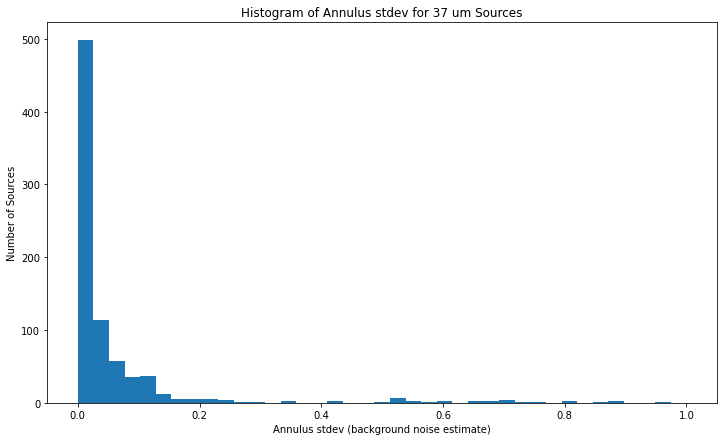

In [51]:
#now lets look at some quality flags...
binlist=np.linspace(0,1.0,40)

plt.figure(figsize=(12,7))
plt.title('Histogram of Annulus stdev for 37 um Sources')
plt.hist(mastercat37['ann_bkg_std'],bins=binlist)
plt.xlabel('Annulus stdev (background noise estimate)')
plt.ylabel('Number of Sources')
#plt.xlim(0,37)
plt.show()

In [52]:
#add quality flags for background noise
bkgmean=np.mean(mastercat37['ann_bkg_std'])
bkgstd=np.std(mastercat37['ann_bkg_std'])

print("average noise measurement for all sources: ", bkgmean, ", standard deviation of noise measurements: ", bkgstd)

bkgstd1sig=mastercat37['ann_bkg_std']>bkgmean+bkgstd
bkgstd2sig=mastercat37['ann_bkg_std']>bkgmean+2*bkgstd
bkgstd3sig=mastercat37['ann_bkg_std']>bkgmean+3*bkgstd


mastercat37['bkg_qflag']=0
mastercat37['bkg_qflag'][bkgstd1sig]=1
mastercat37['bkg_qflag'][bkgstd2sig]=2
mastercat37['bkg_qflag'][bkgstd3sig]=3

average noise measurement for all sources:  0.06808630707021804 , standard deviation of noise measurements:  0.15644873655318806


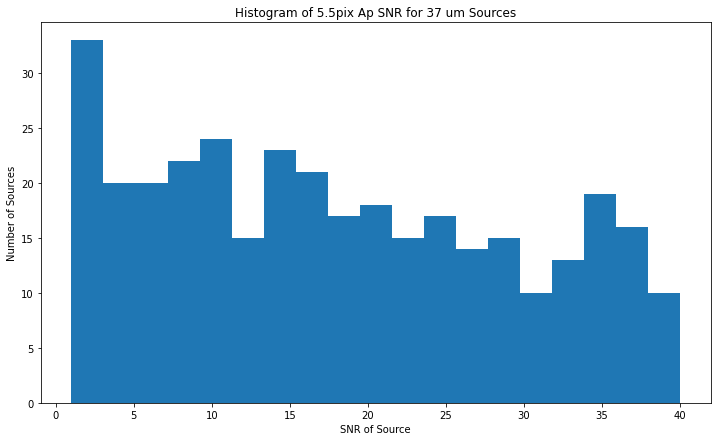

In [53]:
#now lets look at SNR distrobution
binlist=np.linspace(1,40,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of 5.5pix Ap SNR for 37 um Sources')
plt.hist(mastercat37['aper_snr_5.5pix'],bins=binlist)
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()


In [54]:
#check if there are masked elements before applying cut
np.ma.getmask(mastercat37['aper_snr_5.5pix'])

False

In [55]:
#lets examine SNR cuts...
snrcut4pix=mastercat37['aper_snr_5.5pix']>=0.5 #max snr in all computed apertures must be gtreq to 5
mcat37snrcut=mastercat37[snrcut4pix] #apply snr cut

print("Number of Catalog Sources after SNR cut: ", len(mcat37snrcut))

Number of Catalog Sources after SNR cut:  689


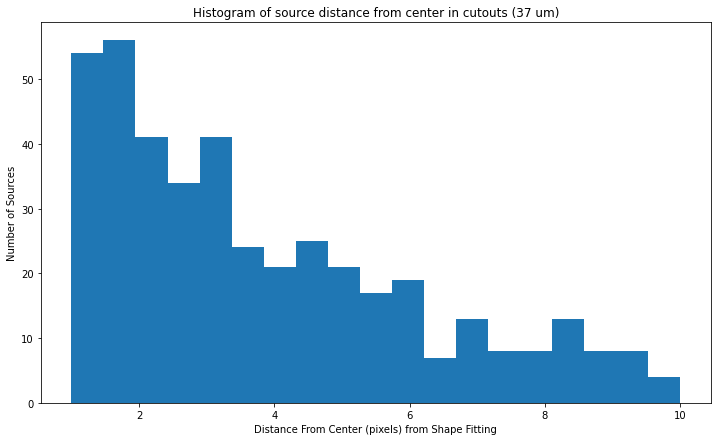

In [56]:
binlist=np.linspace(1,10,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of source distance from center in cutouts (37 um)')
plt.hist(mcat37snrcut['fit_dist'],bins=binlist)
plt.xlabel('Distance From Center (pixels) from Shape Fitting')
plt.ylabel('Number of Sources')
#plt.xlim(0,37)
plt.show()

In [57]:
print('Central distance fit mean: ', np.mean(mcat37snrcut['fit_dist']), '  stdev: ',np.std(mcat37snrcut['fit_dist']))

Central distance fit mean:  4.614870366636117   stdev:  11.056518281262285


In [58]:
sigma_clipped_stats(mcat37snrcut['fit_dist'],sigma=3)

(2.62881587570484, 1.8309429571879683, 2.30288535001784)

In [59]:
#apply quality flags to table
Distmean=np.mean(mcat37snrcut['fit_dist'])
Diststd=np.std(mcat37snrcut['fit_dist'])

distidx1=mcat37snrcut['fit_dist']>4.0
distidx2=mcat37snrcut['fit_dist']>7.0

mcat37snrcut['shape_qflag']=0

mcat37snrcut['shape_qflag'][distidx1]=10
mcat37snrcut['shape_qflag'][distidx1]=mcat37snrcut['shape_qflag'][distidx1]+10

In [60]:
#old - I think these come from shape fitting parameters which is depreciated. 

#binlist=np.linspace(0,80,40)

#plt.figure(figsize=(12,7))
#plt.title('Shape Parameters fit Errors')
#plt.hist(mcat37snrcut['covar_sigx2'],bins=binlist,label=r'$\sigma_x^2$')
#plt.hist(mcat37snrcut['covar_sigy2'],bins=binlist,label=r'$\sigma_y^2$')
#plt.xlabel('Error functions from shape fitting')
#plt.ylabel('Number of Sources')
#plt.legend()
#plt.show()

In [61]:
#print('Covar X^2 mean: ', np.mean(mcat37snrcut['covar_sigx2']), '  stdev: ',np.std(mcat37snrcut['covar_sigx2']))
#print('Covar Y^2 mean: ', np.mean(mcat37snrcut['covar_sigy2']), '  stdev: ',np.std(mcat37snrcut['covar_sigy2']))

In [62]:
#add quality flags to table
#sigXmean=np.mean(mcat37snrcut['covar_sigx2'])
#sigXstd=np.std(mcat37snrcut['covar_sigx2'])

#sigYmean=np.mean(mcat37snrcut['covar_sigy2'])
#sigYstd=np.std(mcat37snrcut['covar_sigy2'])

#sigXidx=mcat37snrcut['covar_sigx2']>sigXmean+2*sigXstd
#sigYidx=mcat37snrcut['covar_sigy2']>sigYmean+2*sigYstd

#mcat37snrcut['shape_qflag'][sigXidx]=mcat37snrcut['shape_qflag'][sigXidx]+1
#mcat37snrcut['shape_qflag'][sigYidx]=mcat37snrcut['shape_qflag'][sigYidx]+1

In [63]:
mcat37snrcut

finder,xcentroid,ycentroid,sky_center,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_10.5pix,aperture_sum_err_10.5pix,aperture_sum_14pix,aperture_sum_err_14pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_5.5pix,aper_5.5pix_noise,aper_snr_5.5pix,aper_area_5.5pix,aper_sum_bkgsub_10.5pix,aper_10.5pix_noise,aper_snr_10.5pix,aper_area_10.5pix,aper_sum_bkgsub_14pix,aper_14pix_noise,aper_snr_14pix,aper_area_14pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [31,31]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch,bkg_qflag,shape_qflag
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17,int64,int32,int32
6,240.62999855874736,79.84882164503718,"266.0954459447447,-29.53509122011674",4.196739660858178,0.19983777652040297,9.689087998999568,0.38085019357986183,12.61930988431676,0.5084012944550559,947.6871945508238,0.0007800663556750203,0.0018714687757614905,0.012005648034156591,352.5610656738281,343.8367774021303,4.119091808048325,0.21177493264685823,19.45032755560852,99.54006123320286,9.406090452808286,0.38661899690537616,24.329095383562848,362.7865041639873,12.116203135532258,0.5128156223067839,23.626821431512337,644.9537851804218,Field52,37,8.383068551097487,5.298215281064456,5.8605408503544005,2.752970714793204,2.1929047476227512,-65.53821698529143,1.2553991311193977,5.283798699889057,7.1038802887663515,2.907497585520356,10.017469251881133,5.906352458621346,-1.0,-1.0,0.05893657626392509,358.01893563076885,-1.0,2025.892314797725,-1.0,10.172762697589626,9.552560741916231,10.869631483286659,1.137876196441356,0.19760787953086753,8.350620605260884,0.30889297716498537,111.67399485660859,0.25288280476553854,8.352388324387412,0.3085618607958038,111.70558858815399,0.24769652529937763,0,-0.02684167025505188 .. 0.015783896846395883,0.617577294932216,0.6049116316956675,M,266.0954459447447,-29.53509122011674,359.3481679327174,-0.0823535656824862,1,"266.0954459447447,-29.53509122011674",SFGC359.348-0.082,0,0,0
6,232.19490707867826,163.50403223738354,"266.0975156320235,-29.517244919729375",4.381759357056327,0.19283683224784043,8.562110614754781,0.36805812267770266,9.136643020414304,0.4907480667187753,947.6871945508238,0.0002194642924670752,0.0005063012102199571,0.01206130794773741,368.5865783691406,368.53841211324203,4.359913867945654,0.20479130666831868,21.28954563001543,99.54006123320286,8.482491931301828,0.37438775437377037,22.656969498081725,362.7865041639873,8.995098694275722,0.4963332530757569,18.123103053308363,644.9537851804218,Field52,37,5.959228542037446,6.088471899594584,6.016967157926574,3.035557466194707,1.9604043903216997,29.217316952364765,1.5484343338450575,7.934789432935818,5.123005071227206,1.5093033043278898,7.82185223837242,6.501247238707408,-1.0,-1.0,0.061480249888118295,319.37218360707726,-1.0,2085.847720564139,-1.0,8.943259146228167,7.265033684239297,10.843159500669936,1.4925133140391345,1.9260521194543827,7.780579735620802,0.28449030911696566,105.23

In [64]:
#check if there are masked elements before applying cut
np.ma.is_masked(mcat37snrcut['fit_fwhm'])

True

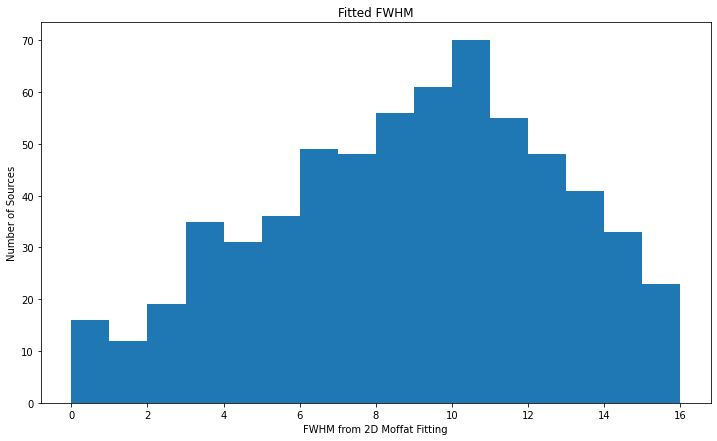

In [65]:
binlist=np.linspace(0,16,17)

plt.figure(figsize=(12,7))
plt.title('Fitted FWHM')
plt.hist(mcat37snrcut['fit_fwhm'],bins=binlist)
plt.xlabel('FWHM from 2D Moffat Fitting')
plt.ylabel('Number of Sources')
plt.show()

In [66]:
# only keep sources with reasonable FWHM - note this will also drop masked values
update37=mcat37snrcut[mcat37snrcut['fit_fwhm']>1.0]

In [67]:
update37

finder,xcentroid,ycentroid,sky_center,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_10.5pix,aperture_sum_err_10.5pix,aperture_sum_14pix,aperture_sum_err_14pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_5.5pix,aper_5.5pix_noise,aper_snr_5.5pix,aper_area_5.5pix,aper_sum_bkgsub_10.5pix,aper_10.5pix_noise,aper_snr_10.5pix,aper_area_10.5pix,aper_sum_bkgsub_14pix,aper_14pix_noise,aper_snr_14pix,aper_area_14pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [31,31]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch,bkg_qflag,shape_qflag
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17,int64,int32,int32
6,240.62999855874736,79.84882164503718,"266.0954459447447,-29.53509122011674",4.196739660858178,0.19983777652040297,9.689087998999568,0.38085019357986183,12.61930988431676,0.5084012944550559,947.6871945508238,0.0007800663556750203,0.0018714687757614905,0.012005648034156591,352.5610656738281,343.8367774021303,4.119091808048325,0.21177493264685823,19.45032755560852,99.54006123320286,9.406090452808286,0.38661899690537616,24.329095383562848,362.7865041639873,12.116203135532258,0.5128156223067839,23.626821431512337,644.9537851804218,Field52,37,8.383068551097487,5.298215281064456,5.8605408503544005,2.752970714793204,2.1929047476227512,-65.53821698529143,1.2553991311193977,5.283798699889057,7.1038802887663515,2.907497585520356,10.017469251881133,5.906352458621346,-1.0,-1.0,0.05893657626392509,358.01893563076885,-1.0,2025.892314797725,-1.0,10.172762697589626,9.552560741916231,10.869631483286659,1.137876196441356,0.19760787953086753,8.350620605260884,0.30889297716498537,111.67399485660859,0.25288280476553854,8.352388324387412,0.3085618607958038,111.70558858815399,0.24769652529937763,0,-0.02684167025505188 .. 0.015783896846395883,0.617577294932216,0.6049116316956675,M,266.0954459447447,-29.53509122011674,359.3481679327174,-0.0823535656824862,1,"266.0954459447447,-29.53509122011674",SFGC359.348-0.082,0,0,0
6,232.19490707867826,163.50403223738354,"266.0975156320235,-29.517244919729375",4.381759357056327,0.19283683224784043,8.562110614754781,0.36805812267770266,9.136643020414304,0.4907480667187753,947.6871945508238,0.0002194642924670752,0.0005063012102199571,0.01206130794773741,368.5865783691406,368.53841211324203,4.359913867945654,0.20479130666831868,21.28954563001543,99.54006123320286,8.482491931301828,0.37438775437377037,22.656969498081725,362.7865041639873,8.995098694275722,0.4963332530757569,18.123103053308363,644.9537851804218,Field52,37,5.959228542037446,6.088471899594584,6.016967157926574,3.035557466194707,1.9604043903216997,29.217316952364765,1.5484343338450575,7.934789432935818,5.123005071227206,1.5093033043278898,7.82185223837242,6.501247238707408,-1.0,-1.0,0.061480249888118295,319.37218360707726,-1.0,2085.847720564139,-1.0,8.943259146228167,7.265033684239297,10.843159500669936,1.4925133140391345,1.9260521194543827,7.780579735620802,0.28449030911696566,105.23

In [68]:
#Optional - write 'master' catalogs to fits prior to quality cuts
update37.write('masterCat_37um_Step3.fits',overwrite=True)

In [69]:
#write out save ds9 region files - optional for testing
makeDS9reg('mastercat_37um_Step3_labelID.reg', update37, r, color='magenta', label="id");

## Crossmatch the 25 and 37 um catalogs

In [70]:
#get source coordinates from both tables
sources25=update25['sky_centroid']#mcat25snrcut
sources37=update37['sky_centroid']#mcat37snrcut

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = sources25.search_around_sky(sources37, 3.0*u.arcsec)
print('Number of crossmatched 25/37 sources found: ', len(idx))

Number of crossmatched 25/37 sources found:  415


In [71]:
def remove_duplicates2(cat1,cat2,radius):
    
    #get source coordinates from both tables
    sources1=cat1['sky_centroid']
    sources2=cat2['sky_centroid']

    #crossmatch source lists to look for duplication
    idx,rdx, d2d, d3d = sources1.search_around_sky(sources2, radius*u.arcsec)
    print('Number of crossmatched 25/37 sources found: ', len(idx))
    
    order=np.argsort(d2d)
    dvals=d2d[order].arcsec
    idxsort=idx[order]
    rdxsort=rdx[order]
    
    catsort1=cat1[rdxsort]  #this cell is where the changes can be made to swap between tables. 
    catsort2=cat2[idxsort]
    #m37=mcat37snrcut[idxsort]
    #m25['xmatchd2d']=np.round(dvals,3)

    sindex=0
    start=catsort1[:sindex]
    
    sourceList=list(start['SourceID'])
    
    #reject_idx=[]
    #reject_rdx=[]
    #d2d_update=[]
    ivals=[]

    for i in range(sindex+1,len(catsort1)):
        newsid=catsort1[i]['SourceID']

        if newsid not in sourceList:
            sourceList.append(newsid)
        else:
            #print(newsid, " is already in source list!")
            #reject_idx.append(idxsort[i])
            #reject_rdx.append(rdxsort[i])
            #d2d_update.append(dvals[i])
            ivals.append(i)



     
    rdxNoDup=np.delete(rdxsort,ivals)    
    idxNoDup=np.delete(idxsort,ivals) 

    cat1nd=cat1[rdxNoDup]
    cat2nd=cat2[idxNoDup]
    
    return cat1nd,cat2nd

In [72]:
m25,m37=remove_duplicates2(update25,update37,3.0)

Number of crossmatched 25/37 sources found:  415


In [73]:
m37,m25=remove_duplicates2(m37,m25,3.0)

Number of crossmatched 25/37 sources found:  420


In [74]:
w, c = np.unique(m25['SourceID'], return_counts=True)
w[c > 1]

<Column name='SourceID' dtype='str17' length=0>

In [75]:
w, c = np.unique(m37['SourceID'], return_counts=True)
w[c > 1]

<Column name='SourceID' dtype='str17' length=0>

In [76]:
#possibly not needed.... - check!
##get source coordinates from both tables
#sources1=m25['sky_centroid']
#sources2=m37['sky_centroid']

##crossmatch source lists to look for duplication
#idx,rdx, d2d, d3d = sources1.search_around_sky(sources2, 5.0*u.arcsec)
#print('Number of crossmatched 25/37 sources found: ', len(idx))

In [77]:
matched25=m25  #[rdx]
matched37=m37  #[idx]
#matched25['xmatchd2d']=np.round(d2d.arcsec,3)

In [78]:
makeDS9reg('matched25.reg',matched25,r,color='red',label='id');
makeDS9reg('matched37.reg',matched37,r,color='cyan',label='id');

In [79]:
match25sid=list(matched25['id'])

i=0
rdx2=[]
for source in update25: #mcat25snrcut
    
    if source['id'] in match25sid:
        #print(i)
        rdx2.append(i)
        
    i=i+1

In [80]:
len(rdx2)

399

In [81]:
match37sid=list(matched37['id'])

i=0
idx2=[]
for source in update37: #mcat37snrcut
    
    if source['id'] in match37sid:
        #print(i)
        idx2.append(i)
        
    i=i+1

In [82]:
len(idx2)

399

In [83]:
#notrdx=findNOTindex(mcat25snrcut,rdx2)
#only25=mcat25snrcut[notrdx]

#notidx=findNOTindex(mcat37snrcut,idx2)
#only37=mcat37snrcut[notidx]

In [84]:
notrdx=findNOTindex(update25,rdx2)
only25=update25[notrdx]

notidx=findNOTindex(update37,idx2)
only37=update37[notidx]

In [85]:
#write out catalogs?
#matched25.write('masterCat_step3_25matched.fits',overwrite=True)
#matched37.write('masterCat_step3_37matched.fits',overwrite=True)
#only25.write('masterCat_step3_25only.fits',overwrite=True)
#only37.write('masterCat_step3_37only.fits',overwrite=True)

## Do fixed aperture photometry for non-detections

In [86]:
#run forced photometry at 37 um
wavelength=37

for info in field._registry:
    filename=info.file37
    name=info.name
    m1cut=info.m1cut
    m2lims=info.m2lims
    
    print('\nScript running on field: ', name)
    
    
    try:
        os.chdir(dpath)
    except:
        os.chdir(dpathalt)
    
    #import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
    hdu=fits.open(filename)
    header=hdu[0].header
    
    #pull the first image plane
    ims=hdu[0].data
    
    #use the first image plane shape to determine how to unpack the rest of the data
    if len(np.shape(ims))==2:
        data=ims
        varmap=hdu[1].data
        tmap=hdu[2].data
    elif len(np.shape(ims))==3:
        data=ims[0]
        varmap=ims[1]
        tmap=ims[2]
        hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
    hdu.close()
    
    #define wcs object for header
    wcsmap=WCS(hdu[0].header)
    
    if not header["PIPELINE"]=='FORCAST_REDUX':
        print("Error! Pipeline that produced data is not FORCAST_REDUX. Check data format because it may not be compatable with this photometry code.")
    
    #talk with James to see if this is going to be best solution moving forward...
    if header["PIPEVERS"]=='1_5_0':
        errormap=np.sqrt(varmap) #in this pipeline version the plane is sigma^2
    elif header["PIPEVERS"]=='2_3_0':
        errormap=varmap #in this version of the pipeline the plane is just sigma
    elif header["PIPEVERS"]=='2_5_0':
        errormap=varmap #in this version of the pipeline the plane is just sigma
    else:
        print("pipeline version not recognized...")
        print("Pipeversion is: "+header["PIPEVERS"])
        print("Assuming 2nd data plane is sigma - Please check validity of this assumption before proceeding!")
        errormap=varmap
    
    #create initial background model for building source mask
    bkg_estimator = MMMBackground()  #Alternates -  SExtractorBackground() or MedianBackground()
    bkg_data = Background2D(data,(25,25),bkg_estimator=bkg_estimator,edge_method='pad')
    #bkg_rms=bkg_data.background_rms
    bkg=bkg_data.background
    
    tmapnorm=tmap/np.max(tmap) #creating a normalized exposure time map for the mask
    maskTPS=np.where(tmapnorm<0.05,tmapnorm,0).astype('bool')

    #create masked array for the background subtracted data
    data_ma = np.ma.masked_array(data, mask=maskTPS)
    
    mask_3sigma = make_source_mask(data_ma-bkg, nsigma=3, npixels=3, dilate_size=3, filter_fwhm=3)

    data_ma2 = np.ma.masked_array(data, mask=mask_3sigma)
    
    #create updated background model detected sources masked
    bkg_data = Background2D(data_ma2,(25,25),bkg_estimator=bkg_estimator,edge_method='pad')
    bkg_rms=bkg_data.background_rms
    bkg=bkg_data.background

    #create background subtracted image
    data_bkgsub = data - bkg

    
    #specify radii to use with source measurements
    radii = [5.5, 10.5, 14] #aperture radii to use in photoemtry - units are pixels
    r_in = 14  #inner radius for background annulus - units are pixels #12 or 15
    r_out = 22  #outer radius for background annulus - units are pixels #20 or 25
    
    
    
    tab=only25[only25['Field']==name]
    
    if len(tab)>0:
        sources = tab['sky_centroid']
        
        CombPhotTable=performApPhoto(data_bkgsub,errormap,tmap,header,sources,radii,r_in,r_out,plot=False)
        
        CombPhotTable['Field']=name
        CombPhotTable['wv']=wavelength
        
        #merge Tables
        mtComb = CombPhotTable
        
        #add shape parameters to table - depreciated
        mtComb=fitshapes(data_bkgsub,mtComb,cutouts=False,cutsize=31) #optional plot=True for diagnostic plots
        
        mtComb=modelSources(data_bkgsub,errormap,mtComb,header,cutouts=False)
        
        mtComb.write(name+'_'+str(wavelength)+'um_Forced.fits', overwrite=True)
        
    else:
        print('No sources found in Combined Source List')    



Script running on field:  Field01


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field02


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field03



Script running on field:  Field04


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field05


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field06



Script running on field:  Field07


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field08



Script running on field:  Field09



Script running on field:  Field10


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field11


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field12


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field13


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field14



Script running on field:  Field15



Script running on field:  Field16



Script running on field:  Field17


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field18


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field19


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field20


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field21


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field22



Script running on field:  Field23


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field24


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field25


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field26



Script running on field:  Field27



Script running on field:  Field28


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field29


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field30



Script running on field:  Field31


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field32


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field33


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field34


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field35
pipeline version not recognized...
Pipeversion is: 2_2_4_dev10+g562377b
Assuming 2nd data plane is sigma - Please check validity of this assumption before proceeding!


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field36


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field37


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field38


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field39


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field40



Script running on field:  Field41


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field42


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field43


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field44



Script running on field:  Field45


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field46


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field47


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field48


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field49


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field50


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field51


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field52


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)


In [87]:
#combine different out files
Cat37Force=CombineFieldResults('Forced',wavelength)

len(Cat37Force)

337

In [88]:
len(only25)

337

In [89]:
#get source coordinates from 'finders' and SEG
OGsources=only25['sky_centroid']
FCsources=Cat37Force['sky_centroid']

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = OGsources.search_around_sky(FCsources, 1.*u.arcsec)
print('Number of crossmatched Finder sources and Seg sources: ', len(idx))

Number of crossmatched Finder sources and Seg sources:  337


In [90]:
matchOG25=only25[rdx]
matchFC37=Cat37Force[idx]

In [91]:
makeDS9reg('only25.reg',matchOG25,r,color='yellow',label='id');

In [92]:
#run forced photometry at 25 um
wavelength=25

for info in field._registry:
    filename=info.file25
    name=info.name
    m1cut=info.m1cut
    m2lims=info.m2lims
    
    print('\nScript running on field: ', name)
    
    
    try:
        os.chdir(dpath)
    except:
        os.chdir(dpathalt)
    
    #import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
    hdu=fits.open(filename)
    header=hdu[0].header
    
    #pull the first image plane
    ims=hdu[0].data
    
    #use the first image plane shape to determine how to unpack the rest of the data
    if len(np.shape(ims))==2:
        data=ims
        varmap=hdu[1].data
        tmap=hdu[2].data
    elif len(np.shape(ims))==3:
        data=ims[0]
        varmap=ims[1]
        tmap=ims[2]
        hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
    hdu.close()
    
    #define wcs object for header
    wcsmap=WCS(hdu[0].header)
    
    if not header["PIPELINE"]=='FORCAST_REDUX':
        print("Error! Pipeline that produced data is not FORCAST_REDUX. Check data format because it may not be compatable with this photometry code.")
    
    #talk with James to see if this is going to be best solution moving forward...
    if header["PIPEVERS"]=='1_5_0':
        errormap=np.sqrt(varmap) #in this pipeline version the plane is sigma^2
    elif header["PIPEVERS"]=='2_3_0':
        errormap=varmap #in this version of the pipeline the plane is just sigma
    elif header["PIPEVERS"]=='2_5_0':
        errormap=varmap #in this version of the pipeline the plane is just sigma
    else:
        print("pipeline version not recognized...")
        print("Pipeversion is: "+header["PIPEVERS"])
        print("Assuming 2nd data plane is sigma - Please check validity of this assumption before proceeding!")
        errormap=varmap
    
    #create initial background model for building source mask
    bkg_estimator = MMMBackground()  #Alternates -  SExtractorBackground() or MedianBackground()
    bkg_data = Background2D(data,(25,25),bkg_estimator=bkg_estimator,edge_method='pad')
    #bkg_rms=bkg_data.background_rms
    bkg=bkg_data.background
    
    tmapnorm=tmap/np.max(tmap) #creating a normalized exposure time map for the mask
    maskTPS=np.where(tmapnorm<0.05,tmapnorm,0).astype('bool')

    #create masked array for the background subtracted data
    data_ma = np.ma.masked_array(data, mask=maskTPS)
    
    mask_3sigma = make_source_mask(data_ma-bkg, nsigma=3, npixels=3, dilate_size=3, filter_fwhm=3)

    data_ma2 = np.ma.masked_array(data, mask=mask_3sigma)
    
    #create updated background model detected sources masked
    bkg_data = Background2D(data_ma2,(25,25),bkg_estimator=bkg_estimator,edge_method='pad')
    bkg_rms=bkg_data.background_rms
    bkg=bkg_data.background

    #create background subtracted image
    data_bkgsub = data - bkg

    
    #specify radii to use with source measurements
    radii = [4, 8, 12] #aperture radii to use in photoemtry - units are pixels
    r_in = 12  #inner radius for background annulus - units are pixels #12 or 15
    r_out = 20  #outer radius for background annulus - units are pixels #20 or 25
    
    tab=only37[only37['Field']==name]
    
    #print(len(tab))
    
    if len(tab)>0:
        sources = tab['sky_centroid']
        
        CombPhotTable=performApPhoto(data_bkgsub,errormap,tmap,header,sources,radii,r_in,r_out,plot=False)
        
        CombPhotTable['Field']=name
        CombPhotTable['wv']=wavelength
        
        #merge Tables
        mtComb = CombPhotTable
        
        #add shape parameters to table - depreciated
        mtComb=fitshapes(data_bkgsub,mtComb,cutouts=False) #optional plot=True for diagnostic plots
        
        mtComb=modelSources(data_bkgsub,errormap,mtComb,header,cutouts=False)
        
        mtComb.write(name+'_'+str(wavelength)+'um_Forced.fits', overwrite=True)

    else:
        print('No sources found in Combined Source List')    



Script running on field:  Field01


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field02



Script running on field:  Field03



Script running on field:  Field04


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field05


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field06


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field07


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field08


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field09


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field10



Script running on field:  Field11


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field12



Script running on field:  Field13


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field14


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field15



Script running on field:  Field16



Script running on field:  Field17



Script running on field:  Field18


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field19


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field20


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field21


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field22



Script running on field:  Field23


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field24



Script running on field:  Field25



Script running on field:  Field26


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field27


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field28


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field29



Script running on field:  Field30



Script running on field:  Field31


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field32



Script running on field:  Field33



Script running on field:  Field34



Script running on field:  Field35
pipeline version not recognized...
Pipeversion is: 2_2_4_dev10+g562377b
Assuming 2nd data plane is sigma - Please check validity of this assumption before proceeding!



Script running on field:  Field36



Script running on field:  Field37


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field38


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field39



Script running on field:  Field40


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field41


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field42



Script running on field:  Field43



Script running on field:  Field44
No sources found in Combined Source List

Script running on field:  Field45



Script running on field:  Field46


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field47



Script running on field:  Field48


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field49



Script running on field:  Field50


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field51



Script running on field:  Field52


In [93]:
#combine different out files
Cat25Force=CombineFieldResults('Forced',wavelength)

len(Cat25Force)

271

In [94]:
Cat25Force

xcentroid,ycentroid,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [25,25]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid
pix,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg"
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object
146.54292660395174,157.82725664868445,1.9338904736692821,0.07220307638173638,5.965561590619748,0.14438156571490976,11.01801894174005,0.2165630143910101,842.3886903474042,0.004527383407342763,0.00832521033010628,0.012598959706843526,402.0951843261719,401.6652307681861,1.69552693746853,0.11714446232614582,14.473812110281036,52.649293146712765,5.012107445816738,0.16231336411924652,30.879203773599937,210.59717258685106,8.872747115933278,0.22733790385557853,39.028894722148436,473.8436383204149,Field52,25,5.692810760391087,7.2277025075453745,7.317249533356344,3.969144396600193,1.8860376421488483,15.24851438591563,2.1044884300813673,14.910415306932512,4.400829921732585,1.139872716625777,8.00076639282287,9.139872458983842,-1.0,-1.0,0.03450937642732619,424.25415968148,-1.0,2006.6525879269464,-1.0,12.11243517281825,1244.4249416782052,7.172772097613904,173.4928873722582,-2.8886079128810986,6.112182682382549,0.16066829280896122,76.74074256100766,1.2345555778449453,6.117173036280216,0.14877758345109748,14.96060448757134,0.38896316742948317,1,0.0 .. 0.0,1.2345555778449453,0.38896316742948317,M,266.12045559357466,-29.517355705314767,359.3746760374839,-0.09162355013695625,1,"266.12045559357466,-29.517355705314767"
147.793013935599,247.6457465393202,1.9217578152475634,0.07270219162396609,5.978034285886448,0.1453742447515076,10.42794439861008,0.2180267639106285,842.3886903474042,0.005276496265563333,0.0059068311419770035,0.006763682975788565,402.0951843261719,401.380556185205,1.6439540165743844,0.09972968850346536,16.484098579303804,52.649293146712765,4.866819091193731,0.1576991640755096,30.861413373525544,210.59717258685106,7.927710210551468,0.2261701647502783,35.051971683819154,473.8436383204149,Field52,25,7.3037314193876295,4.730256453362571,5.812610430665852,3.0132621646408686,1.762422620487579,-82.68371311500195,1.7097273546155696,3.20300848672383,8.98287387933865,2.8962854103792375,8.18171384626541,5.109420601946548,0.7345472891146868,0.9876731013464574,0.037165143037363485,15.054930082255126,1138.896641663979,3.4040006369587656,167.99299312620963,10.989335843726987,9.100057323353884,16.357976104845765,1.7975684683727826,0.046456678939336304,5.792232685044524,0.1567700720701277,87.29246844460414,0.38127692739666785,5.803789948856054,0.15520100568415346,86.0646598720164,0.26540873030124096,0,0.0 .. 0.0,0.38127692739666785,0.26540873030124096,M,266.12014639427986,-29.498194461613537,359.3908659734289,-0.081371

In [95]:
len(only37)

270

In [96]:
#get source coordinates from 'finders' and SEG
OGsources=only37['sky_centroid']
FCsources=Cat25Force['sky_centroid']

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = OGsources.search_around_sky(FCsources, 1*u.arcsec)
print('Number of crossmatched Finder sources and Seg sources: ', len(idx))

Number of crossmatched Finder sources and Seg sources:  270


In [97]:
matchOG37=only37[rdx]
matchFC25=Cat25Force[idx]

In [98]:
makeDS9reg('only37.reg',matchOG37,r,color='green',label='id');

## Build master catalog from other tables

In [99]:
matched25

finder,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [25,25]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch,bkg_qflag,shape_qflag
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17,int64,int32,int32
4,151.9595009827115,176.74495936874513,"266.2330712533565,-29.216098552356616",2.995925881198517,0.07027753136816173,8.365930981323093,0.14027464449067722,11.800442939266407,0.21032044637660105,842.3888721065464,0.0011972284848274597,0.0016486522112697402,0.00473124420800439,539.6475000000004,538.0414812882284,2.93289263413679,0.09090399677213866,32.26362688417786,52.649304506659156,8.113797993076185,0.1512504487070319,53.64478626303051,210.59721802663663,11.233143715710863,0.21784900440962862,51.56389741671169,473.84374055993226,Field44,25,5.617493344183462,5.970884735024533,5.459389583294307,2.678335743821299,1.891130742896901,31.25568531327256,1.4162615429319971,6.2050918574699,4.544765985890677,1.6875001969306078,6.580327612157174,7.087757035742402,-1.0,-1.0,0.06535121045654821,216.54122799690953,-1.0,773.8717773440974,-1.0,9.956513629217682,10.680291960685095,9.213343252645743,1.15922002120328,-2.4976081335110196,9.401050949503311,0.14794674245767483,160.77422391704215,0.2561256074870003,9.390083826875959,0.1475270418112406,160.61898899657274,0.20541667904755684,0,-0.0015149251367636571 .. -0.0020421264020558235,1.0136213811106651,0.8129399475603734,M,266.2330712533565,-29.216098552356616,359.6827963473105,-0.017829654316877618,179,"266.2330712533565,-29.216098552356616",SFGC359.683-0.018,0,0,0
1,64.73597558588324,82.41208554649609,"266.8221549,-28.5393852",5.597180047989988,0.15975379697195638,14.877841706653193,0.35345091923838473,21.885068916392605,0.6013730938073902,842.3888423869209,0.0005255286906487715,0.002053430346457257,0.008041437684087079,108.05580139160156,95.36050645758472,5.569511328905192,0.16937985108852366,32.88178194225934,52.649302649182545,14.767166830314011,0.3577785372348893,41.27460228453852,210.59721059673018,21.636050444629443,0.603931509505449,35.825337979710476,473.8437238426428,Field05,25,6.151825063775684,7.233228290081365,5.000167127924251,2.4223797693473337,1.7746895658835107,-21.970117632405966,1.364959717978269,5.4874346403538885,3.5300121618451565,1.7183712688014743,6.767669387125501,9.19756464460786,0.36845756815570535,0.3677629133390725,0.13289053192028247,6.6211188264122836,32.47339708072545,1.2718192923316585,1.866362786553754,8.657182585344977,8.997083253584012,11.274741663449223,1.2531551999319224,-5.093918313753601,17.40870298353767,0.35780

In [100]:
t1=Table()
t1['SourceID']=matched25['SourceID']
t1['RA(J2000)']=matched25['RA(J2000)']
t1['DEC(J2000)']=matched25['DEC(J2000)']
t1['25um_Flux_4pix']=matched25['aper_sum_bkgsub_4pix']
t1['25um_Flux_err_4pix']=matched25['aper_4pix_noise']
t1['25um_SNR_4pix']=matched25['aper_snr_4pix']
t1['25um_Flux_8pix']=matched25['aper_sum_bkgsub_8pix']
t1['25um_Flux_err_8pix']=matched25['aper_8pix_noise']
t1['25um_SNR_8pix']=matched25['aper_snr_8pix']
t1['25um_Flux_12pix']=matched25['aper_sum_bkgsub_12pix']
t1['25um_Flux_err_12pix']=matched25['aper_12pix_noise']
t1['25um_SNR_12pix']=matched25['aper_snr_12pix']
t1['25ApRatio8_4']=matched25['aper_sum_bkgsub_8pix']/matched25['aper_sum_bkgsub_4pix']
t1['25ApRatio12_8']=matched25['aper_sum_bkgsub_12pix']/matched25['aper_sum_bkgsub_8pix']
t1['25ApRatio12_8']=matched25['aper_sum_bkgsub_12pix']

t1['25um_Flux_M2D']=matched25['FluxMoffat2D']
t1['25um_Flux_err_M2D']=matched25['FluxMoffatErr']
t1['25um_M2D_chi2']=matched25['Moffat2DChi2']
t1['25um_Flux_G2D']=matched25['FluxGauss2D']
t1['25um_Flux_err_G2D']=matched25['FluxGauss2DErr']
t1['25um_G2D_chi2']=matched25['Gauss2DChi2']
t1['25um_BestModel']=matched25['BestModel']
t1['fwhm25']=matched25['fit_fwhm'] #np.sqrt(matched25['fit_xfwhm']*matched25['fit_yfwhm'])
t1['elong25']=matched25['fit_elong']

t1['bkg_qflag25']=matched25['bkg_qflag']
t1['shape_qflag25']=matched25['shape_qflag']
t1['cutout25']=matched25['cutouts']

t1['37um_Flux_5.5pix']=matched37['aper_sum_bkgsub_5.5pix']
t1['37um_Flux_err_5.5pix']=matched37['aper_5.5pix_noise']
t1['37um_SNR_5.5pix']=matched37['aper_snr_5.5pix']
t1['37um_Flux_10.5pix']=matched37['aper_sum_bkgsub_10.5pix']
t1['37um_Flux_err_10.5pix']=matched37['aper_10.5pix_noise']
t1['37um_SNR_10.5pix']=matched37['aper_snr_10.5pix']
t1['37um_Flux_14pix']=matched37['aper_sum_bkgsub_14pix']
t1['37um_Flux_err_14pix']=matched37['aper_14pix_noise']
t1['37um_SNR_14pix']=matched37['aper_snr_14pix']
t1['37ApRatio10.5_5.5']=matched37['aper_sum_bkgsub_10.5pix']/matched37['aper_sum_bkgsub_5.5pix']
t1['37ApRatio14_10.5']=matched37['aper_sum_bkgsub_14pix']/matched37['aper_sum_bkgsub_10.5pix']

t1['37um_Flux_M2D']=matched37['FluxMoffat2D']
t1['37um_Flux_err_M2D']=matched37['FluxMoffatErr']
t1['37um_M2D_chi2']=matched37['Moffat2DChi2']
t1['37um_Flux_G2D']=matched37['FluxGauss2D']
t1['37um_Flux_err_G2D']=matched37['FluxGauss2DErr']
t1['37um_G2D_chi2']=matched37['Gauss2DChi2']
t1['37um_BestModel']=matched37['BestModel']
t1['fwhm37']=matched37['fit_fwhm'] #np.sqrt(matched37['fit_xfwhm']*matched37['fit_yfwhm'])
t1['elong37']=matched37['fit_elong']

t1['bkg_qflag37']=matched37['bkg_qflag']
t1['shape_qflag37']=matched37['shape_qflag']
t1['cutout37']=matched37['cutouts']

t1['sky_centroid']=matched25['sky_centroid']
t1['FieldID']=matched25['Field']
t1['SID25']=matched25['SourceID']
t1['SID37']=matched37['SourceID']



t2=Table()
t2['SourceID']=matchOG25['SourceID']
t2['RA(J2000)']=matchOG25['RA(J2000)']
t2['DEC(J2000)']=matchOG25['DEC(J2000)']
t2['25um_Flux_4pix']=matchOG25['aper_sum_bkgsub_4pix']
t2['25um_Flux_err_4pix']=matchOG25['aper_4pix_noise']
t2['25um_SNR_4pix']=matchOG25['aper_snr_4pix']
t2['25um_Flux_8pix']=matchOG25['aper_sum_bkgsub_8pix']
t2['25um_Flux_err_8pix']=matchOG25['aper_8pix_noise']
t2['25um_SNR_8pix']=matchOG25['aper_snr_8pix']
t2['25um_Flux_12pix']=matchOG25['aper_sum_bkgsub_12pix']
t2['25um_Flux_err_12pix']=matchOG25['aper_12pix_noise']
t2['25um_SNR_12pix']=matchOG25['aper_snr_12pix']
t2['25ApRatio8_4']=matchOG25['aper_sum_bkgsub_8pix']/matchOG25['aper_sum_bkgsub_4pix']
t2['25ApRatio12_8']=matchOG25['aper_sum_bkgsub_12pix']/matchOG25['aper_sum_bkgsub_8pix']

t2['25um_Flux_M2D']=matchOG25['FluxMoffat2D']
t2['25um_Flux_err_M2D']=matchOG25['FluxMoffatErr']
t2['25um_M2D_chi2']=matchOG25['Moffat2DChi2']
t2['25um_Flux_G2D']=matchOG25['FluxGauss2D']
t2['25um_Flux_err_G2D']=matchOG25['FluxGauss2DErr']
t2['25um_G2D_chi2']=matchOG25['Gauss2DChi2']
t2['25um_BestModel']=matchOG25['BestModel']
t2['fwhm25']=matchOG25['fit_fwhm'] #np.sqrt(matchOG25['fit_yfwhm']*matchOG25['fit_yfwhm'])
t2['elong25']=matchOG25['fit_elong']

t2['bkg_qflag25']=matchOG25['bkg_qflag']
t2['shape_qflag25']=matchOG25['shape_qflag']
t2['cutout25']=matchOG25['cutouts']
t2['37um_Flux_5.5pix']=matchFC37['aper_sum_bkgsub_5.5pix']
t2['37um_Flux_err_5.5pix']=matchFC37['aper_5.5pix_noise']
t2['37um_SNR_5.5pix']=matchFC37['aper_snr_5.5pix']
t2['37um_Flux_10.5pix']=matchFC37['aper_sum_bkgsub_10.5pix']
t2['37um_Flux_err_10.5pix']=matchFC37['aper_10.5pix_noise']
t2['37um_SNR_10.5pix']=matchFC37['aper_snr_10.5pix']
t2['37um_Flux_14pix']=matchFC37['aper_sum_bkgsub_14pix']
t2['37um_Flux_err_14pix']=matchFC37['aper_14pix_noise']
t2['37um_SNR_14pix']=matchFC37['aper_snr_14pix']
t2['37ApRatio10.5_5.5']=matchFC37['aper_sum_bkgsub_10.5pix']/matchFC37['aper_sum_bkgsub_5.5pix']
t2['37ApRatio14_10.5']=matchFC37['aper_sum_bkgsub_14pix']/matchFC37['aper_sum_bkgsub_10.5pix']

t2['37um_Flux_M2D']=matchFC37['FluxMoffat2D']
t2['37um_Flux_err_M2D']=matchFC37['FluxMoffatErr']
t2['37um_M2D_chi2']=matchFC37['Moffat2DChi2']
t2['37um_Flux_G2D']=matchFC37['FluxGauss2D']
t2['37um_Flux_err_G2D']=matchFC37['FluxGauss2DErr']
t2['37um_G2D_chi2']=matchFC37['Gauss2DChi2']
t2['37um_BestModel']=matchFC37['BestModel']
t2['fwhm37']=matchFC37['fit_fwhm']#np.sqrt(matchFC37['fit_xfwhm']*matchFC37['fit_yfwhm'])
t2['elong37']=matchFC37['fit_elong']

#t2['bkg_qflag37']=matchFC37['bkg_qflag']
#t2['shape_qflag37']=matchFC37['shape_qflag']
#t2['cutout37']=matchFC37['cutouts']
t2['sky_centroid']=matchOG25['sky_centroid']
t2['FieldID']=matchOG25['Field']
t2['SID25']=matchOG25['SourceID']
t2['SID37']=""



t3=Table()
t3['SourceID']=matchOG37['SourceID']
t3['RA(J2000)']=matchOG37['RA(J2000)']
t3['DEC(J2000)']=matchOG37['DEC(J2000)']
t3['25um_Flux_4pix']=matchFC25['aper_sum_bkgsub_4pix']
t3['25um_Flux_err_4pix']=matchFC25['aper_4pix_noise']
t3['25um_SNR_4pix']=matchFC25['aper_snr_4pix']
t3['25um_Flux_8pix']=matchFC25['aper_sum_bkgsub_8pix']
t3['25um_Flux_err_8pix']=matchFC25['aper_8pix_noise']
t3['25um_SNR_8pix']=matchFC25['aper_snr_8pix']
t3['25um_Flux_12pix']=matchFC25['aper_sum_bkgsub_12pix']
t3['25um_Flux_err_12pix']=matchFC25['aper_12pix_noise']
t3['25um_SNR_12pix']=matchFC25['aper_snr_12pix']
t3['25ApRatio8_4']=matchFC25['aper_sum_bkgsub_8pix']/matchFC25['aper_sum_bkgsub_4pix']
t3['25ApRatio12_8']=matchFC25['aper_sum_bkgsub_12pix']/matchFC25['aper_sum_bkgsub_8pix']

t3['25um_Flux_M2D']=matchFC25['FluxMoffat2D']
t3['25um_Flux_err_M2D']=matchFC25['FluxMoffatErr']
t3['25um_M2D_chi2']=matchFC25['Moffat2DChi2']
t3['25um_Flux_G2D']=matchFC25['FluxGauss2D']
t3['25um_Flux_err_G2D']=matchFC25['FluxGauss2DErr']
t3['25um_G2D_chi2']=matchFC25['Gauss2DChi2']
t3['25um_BestModel']=matchFC25['BestModel']
t3['fwhm25']=matchFC25['fit_fwhm'] #np.sqrt(matchFC25['fit_xfwhm']*matchFC25['fit_yfwhm'])
t3['elong25']=matchFC25['fit_elong']

#t3['bkg_qflag25']=matchFC25['bkg_qflag']
#t3['shape_qflag25']=matchFC25['shape_qflag']
#t3['cutout25']=matchFC25['cutouts']
t3['37um_Flux_5.5pix']=matchOG37['aper_sum_bkgsub_5.5pix']
t3['37um_Flux_err_5.5pix']=matchOG37['aper_5.5pix_noise']
t3['37um_SNR_5.5pix']=matchOG37['aper_snr_5.5pix']
t3['37um_Flux_10.5pix']=matchOG37['aper_sum_bkgsub_10.5pix']
t3['37um_Flux_err_10.5pix']=matchOG37['aper_10.5pix_noise']
t3['37um_SNR_10.5pix']=matchOG37['aper_snr_10.5pix']
t3['37um_Flux_14pix']=matchOG37['aper_sum_bkgsub_14pix']
t3['37um_Flux_err_14pix']=matchOG37['aper_14pix_noise']
t3['37um_SNR_14pix']=matchOG37['aper_snr_14pix']
t3['37ApRatio10.5_5.5']=matchOG37['aper_sum_bkgsub_10.5pix']/matchOG37['aper_sum_bkgsub_5.5pix']
t3['37ApRatio14_10.5']=matchOG37['aper_sum_bkgsub_14pix']/matchOG37['aper_sum_bkgsub_10.5pix']

t3['37um_Flux_M2D']=matchOG37['FluxMoffat2D']
t3['37um_Flux_err_M2D']=matchOG37['FluxMoffatErr']
t3['37um_M2D_chi2']=matchOG37['Moffat2DChi2']
t3['37um_Flux_G2D']=matchOG37['FluxGauss2D']
t3['37um_Flux_err_G2D']=matchOG37['FluxGauss2DErr']
t3['37um_G2D_chi2']=matchOG37['Gauss2DChi2']
t3['37um_BestModel']=matchOG37['BestModel']
t3['fwhm37']=matchOG37['fit_fwhm'] #np.sqrt(matchOG37['fit_xfwhm']*matchOG37['fit_yfwhm'])
t3['elong37']=matchOG37['fit_elong']

t3['bkg_qflag37']=matchOG37['bkg_qflag']
t3['shape_qflag37']=matchOG37['shape_qflag']
t3['cutout37']=matchOG37['cutouts']
t3['sky_centroid']=matchOG37['sky_centroid']
t3['FieldID']=matchOG37['Field']
t3['SID25']=""
t3['SID37']=matchOG37['SourceID']

In [101]:
mastercat=vstack((t1,t2,t3))

In [102]:
#change format of columns to save fewer decimal places

if 'sky_centroid' in mastercat.columns:
    skycoords=mastercat['sky_centroid']
    mastercat.remove_columns('sky_centroid')
    

for col in mastercat.colnames:
    if col!='RA(J2000)' and col!='DEC(J2000)' and col!='type' and col!='SourceID' and col!='25um_BestModel' and col!='37um_BestModel' and col!='FieldID' and col!='SID25' and col!='SID37': #skip columns that aren't relevant
        mastercat[col].info.format = '%.4G'

        
if 'sky_centroid' not in mastercat.columns:
    mastercat['sky_centroid']=skycoords
        
        
#display catalog
mastercat

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",FieldID,SID25,SID37,sky_centroid
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,bytes7,str17,str17,object
SFGC359.683-0.018,266.2330712533565,-29.216098552356616,2.933,0.0909,32.26,8.114,0.1513,53.64,11.23,0.2178,51.56,2.766,11.23,9.401,0.1479,0.2561,9.39,0.1475,0.2054,M,9.957,1.159,0,0,-0.001515 .. -0.002042,5.138,0.1118,45.94,11.11,0.1925,57.74,13.38,0.2518,53.12,2.163,1.204,9.982,0.1497,0.2585,9.973,0.1493,0.2023,M,10.31,1.166,0,0,0.001353 .. -0.001666,Field44,SFGC359.683-0.018,SFGC359.683-0.018,"266.2330712533565,-29.216098552356616"
SFGC0.529-0.106,266.8221549,-28.5393852,5.57,0.1694,32.88,14.77,0.3578,41.27,21.64,0.6039,35.83,2.651,21.64,17.41,0.3578,0.4567,17.27,0.3492,0.43,M,8.657,1.253,0,0,0.0005255 .. 0.01497,8.512,0.4013,21.21,23.37,0.9108,25.66,31.51,1.354,23.26,2.746,1.348,18.78,0.7153,0.2551,--,--,--,M,10.86,1,0,20,0.001021 .. -0.00759,Field05,SFGC0.529-0.106,SFGC0.529-0.106,"266.8221549,-28.5393852"
SFGC0.513-0.047,266.7547043,-28.5219786,11.66,0.1934,60.29,29.89,0.4415,67.7,42.05,0.7028,59.84,2.563,42.05,34.29,0.3782,1.247,34.4,0.3759,1.317,M,9.291,1.151,0,0,0.04628 .. 0.0005255,24.68,0.3796,65.02,62.91,0.7154,87.93,87.74,1.087,80.69,2.549,1.395,52.88,0.5634,0.6195,52.83,0.5607,0.4582,M,12.14,1.234,0,0,-0.001246 .. 0.01377,Field05,SFGC0.513-0.047,SFGC0.513-0.047,"266.7547043,-28.5219786"
SFGC0.429-0.011,266.6701335,-28.5752922,1.804,0.1767,10.21,2.405,0.336,7.157,2.726,0.4967,5.488,1.333,2.726,2.328,0.1616,0.1158,1.942,0.1355,0.1231,M,2.71,1.099,0,0,-0.0003879 .. -0.005791,1.057,0.438,2.412,1.016,0.8318,1.221,0.6296,1.188,0.5302,0.9611,0.62,1.153,0.3095,0.08431,1.547,0.3964,0.07971,M,3.788,2.105,0,0,-0.005861 .. 9.348E-05,Field08,SFGC0.429-0.011,SFGC0.429-0.011,"266.6701335,-28.5752922"
SFGC0.285-0.078,266.6505575,-28.7329033,2.8,0.1728,16.21,4.33,0.3638,11.9,4.65,0.6124,7.592,1.547,4.65,4.528,0.222,0.2139,4.072,0.1998,0.2325,M,3.728,1.215,0,0,0.0001371 .. 0.01309,4.965,0.4775,10.4,9.246,1.057,8.749,10.16,1.5,6.771,1.862,1.099,8.445,0.6263,0.209,7.549,0.5624,0.2364,M,4.417,1.237,0,0,0.0001491 .. -0.01914,Field11,SFGC0.285-0.078,SFGC0.285-0.078,"266.6505575,-28.7329033"
SFGC0.180-0.098,266.6078134,-28.8334936,0.461,0.1866,2.47,0.1379,1.051,0.1312,-0.3299,0.7017,-0.4701,0.2992,-0.3299,0.4622,0.05271,0.3686,0.4447,0.05061,0.3671,M,1.923,1.257,0,0,-0.01844 .. -0.005646,0.8058,0.3375,2.387,0.773,0.6533,1.183,1.537,0.7119,2.159,0.9592,1.989,0.8362,0.1526,0.1812,0.826,0.1501,0.1802,M,3.16,1.2,0,0,0.0009319 .. 0.02235,Field18,SFGC0.180-0.098,SFGC0.180-0.098,"266.6078134,-28.8334936"
SFGC0.036-0.182,266.603681,-29.0003732,1.318,0.2007,6.569,1.063,0.3837,2.77,0.4892,0.7523,0.6503,0.8061,0.4892,1.368,0.1332,0.3215,1.368,0.1332,0.3214,M,2.598,1.017,0,0,-0.01921 .. -0.009346,1.413,0.2726,5.184,1.781,0.5579,3.193,2.056,0.8018,2.564,1.261,1.154,1.51,0.1893,0.1474,1.533,0.1911,0.1446,M,4.091,1.232,0,0,-0.004702 .

In [103]:
#check for duplication
u, c = np.unique(mastercat['SourceID'], return_counts=True)
u[c > 1]

SFGC0.153+0.024
SFGC0.159-0.047
SFGC0.159-0.062
SFGC0.200-0.056
SFGC0.602-0.050
SFGC0.658-0.041
SFGC359.400-0.096
SFGC359.410+0.032
SFGC359.938-0.037


In [104]:
mastercat[mastercat['SourceID']=='SFGC0.159-0.047']

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",FieldID,SID25,SID37,sky_centroid
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,bytes7,str17,str17,object
SFGC0.159-0.047,266.5450173766235,-28.825173321452496,12.93,0.08778,147.3,33.74,0.143,235.9,48.95,0.205,238.9,2.609,48.95,38.78,0.4674,12.53,38.7,0.3692,7.969,A,9.151,1.333,0,0,-0.001858 .. 0.006838,24.74,0.1982,124.8,50.03,0.3641,137.4,60.76,0.4824,125.9,2.023,1.214,45.86,0.6515,5.934,45.72,0.6186,5.412,A,9,1.187,0,0,0.008631 .. 0.1166,Field21,SFGC0.159-0.047,SFGC0.158-0.047,"266.5450173766235,-28.825173321452496"
SFGC0.159-0.047,266.5452639486969,-28.824268094899818,12.48,0.09114,136.9,35.25,0.1438,245.1,48.89,0.2056,237.8,2.824,1.387,39.89,0.6366,21.74,39.99,0.4274,10.13,A,9.553,1.674,0,0,0.008061 .. 0.02184,37.1,0.2071,179.1,94.64,0.3666,258.2,133.2,0.4839,275.2,2.551,1.407,82.03,1.12,13.89,81.99,0.7501,6.41,A,12.9,2.041,--,--,-- .. --,Field21,SFGC0.159-0.047,,"266.5452639486969,-28.824268094899818"


In [105]:
#quality flag for photometry  - use this flag to indicate upper limits - Still to do...
mastercat['25ApPhot_qflag']=0
mastercat['25Ap_4pix_UL']=0.
mastercat['25Ap_8pix_UL']=0.
mastercat['25Ap_12pix_UL']=0.

crit25=3.0 #flag any sources with SNR<3

#provide upper limits for 25 um sources
crit1=mastercat['25um_SNR_4pix']<crit25
mastercat['25ApPhot_qflag'][crit1]=100
mastercat['25Ap_4pix_UL'][crit1]=mastercat['25um_Flux_4pix'][crit1]+3*mastercat['25um_Flux_err_4pix'][crit1]


crit2=mastercat['25um_SNR_8pix']<crit25
mastercat['25ApPhot_qflag'][crit2]=mastercat['25ApPhot_qflag'][crit2]+10
mastercat['25Ap_8pix_UL'][crit2]=mastercat['25um_Flux_8pix'][crit2]+3*mastercat['25um_Flux_err_8pix'][crit2]

crit3=mastercat['25um_SNR_12pix']<crit25
mastercat['25ApPhot_qflag'][crit3]=mastercat['25ApPhot_qflag'][crit3]+1
mastercat['25Ap_12pix_UL'][crit3]=mastercat['25um_Flux_12pix'][crit3]+3*mastercat['25um_Flux_err_12pix'][crit3]

In [106]:
#quality flag for photometry
mastercat['37ApPhot_qflag']=0
mastercat['37Ap_5.5pix_UL']=0.
mastercat['37Ap_10.5pix_UL']=0.
mastercat['37Ap_14pix_UL']=0.

crit37=3.0 #flag any sources with SNR<3

#provide upper limits for 37 um sources
crit4=mastercat['37um_SNR_5.5pix']<crit37
mastercat['37ApPhot_qflag'][crit4]=100
mastercat['37Ap_5.5pix_UL'][crit4]=mastercat['37um_Flux_5.5pix'][crit4]+3*mastercat['37um_Flux_err_5.5pix'][crit4]

crit5=mastercat['37um_SNR_10.5pix']<crit37
mastercat['37ApPhot_qflag'][crit5]=mastercat['37ApPhot_qflag'][crit5]+10
mastercat['37Ap_10.5pix_UL'][crit5]=mastercat['37um_Flux_10.5pix'][crit5]+3*mastercat['37um_Flux_err_10.5pix'][crit5]


crit6=mastercat['37um_SNR_14pix']<crit37
mastercat['37ApPhot_qflag'][crit6]=mastercat['37ApPhot_qflag'][crit6]+1
mastercat['37Ap_14pix_UL'][crit6]=mastercat['37um_Flux_14pix'][crit6]+3*mastercat['37um_Flux_err_14pix'][crit6]


In [107]:
#add an ID to table for easy tracking of sources in human vetting
mastercat['id']=np.linspace(1,len(mastercat),len(mastercat),dtype=np.int64)

In [108]:
mastercat

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",FieldID,SID25,SID37,sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,bytes7,str17,str17,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC359.683-0.018,266.2330712533565,-29.216098552356616,2.933,0.0909,32.26,8.114,0.1513,53.64,11.23,0.2178,51.56,2.766,11.23,9.401,0.1479,0.2561,9.39,0.1475,0.2054,M,9.957,1.159,0,0,-0.001515 .. -0.002042,5.138,0.1118,45.94,11.11,0.1925,57.74,13.38,0.2518,53.12,2.163,1.204,9.982,0.1497,0.2585,9.973,0.1493,0.2023,M,10.31,1.166,0,0,0.001353 .. -0.001666,Field44,SFGC359.683-0.018,SFGC359.683-0.018,"266.2330712533565,-29.216098552356616",0,0.0,0.0,0.0,0,0.0,0.0,0.0,1
SFGC0.529-0.106,266.8221549,-28.5393852,5.57,0.1694,32.88,14.77,0.3578,41.27,21.64,0.6039,35.83,2.651,21.64,17.41,0.3578,0.4567,17.27,0.3492,0.43,M,8.657,1.253,0,0,0.0005255 .. 0.01497,8.512,0.4013,21.21,23.37,0.9108,25.66,31.51,1.354,23.26,2.746,1.348,18.78,0.7153,0.2551,--,--,--,M,10.86,1,0,20,0.001021 .. -0.00759,Field05,SFGC0.529-0.106,SFGC0.529-0.106,"266.8221549,-28.5393852",0,0.0,0.0,0.0,0,0.0,0.0,0.0,2
SFGC0.513-0.047,266.7547043,-28.5219786,11.66,0.1934,60.29,29.89,0.4415,67.7,42.05,0.7028,59.84,2.563,42.05,34.29,0.3782,1.247,34.4,0.3759,1.317,M,9.291,1.151,0,0,0.04628 .. 0.0005255,24.68,0.3796,65.02,62.91,0.7154,87.93,87.74,1.087,80.69,2.549,1.395,52.88,0.5634,0.6195,52.83,0.5607,0.4582,M,12.14,1.234,0,0,-0.001246 .. 0.01377,Field05,SFGC0.513-0.047,SFGC0.513-0.047,"266.7547043,-28.5219786",0,0.0,0.0,0.0,0,0.0,0.0,0.0,3
SFGC0.429-0.011,266.6701335,-28.5752922,1.804,0.1767,10.21,2.405,0.336,7.157,2.726,0.4967,5.488,1.333,2.726,2.328,0.1616,0.1158,1.942,0.1355,0.1231,M,2.71,1.099,0,0,-0.0003879 .. -0.005791,1.057,0.438,2.412,1.016,0.8318,1.221,0.6296,1.188,0.5302,0.9611,0.62,1.153,0.3095,0.08431,1.547,0.3964,0.07971,M,3.788,2.105,0,0,-0.005861 .. 9.348E-05,Field08,SFGC0.429-0.011,SFGC0.429-0.011,"266.6701335,-28.5752922",0,0.0,0.0,0.0,111,2.370553607439477,3.510969257631465,4.192162078792019,4
SFGC0.285-0.078,266.6505575,-28.7329033,2.8,0.1728,16.21,4.33,0.3638,11.9,4.65,0.6124,7.592,1.547,4.65,4.528,0.222,0.2139,4.072,0.1998,0.2325,M,3.728,1.215,0,0,0.0001371 .. 0.01309,4.965,0.4775,10.4,9.246,1.057,8.749,10.16,1.5,6.771,1.862,1.099,8.445,0.6263,0.209,7.549,0.5624,0.2364,M,4.417,1.237,0,0,0.0001491 .. -0.01914,Field11,SFGC0.285-0.078,SFGC0.285-0.078,"266.6505575,-28.7329033",0,0.0,0.0,0.0,0,0.0,0.0,0.0,5
SFGC0.180-0.098,266.6078134,-28.8334936,0.461,0.1866,2.47,0.1379,1.051,0.1312,-0.3299,0.7017,-0.4701,0.2992,-0.3299,0.4622,0.05271,0.3686,0.4447,0.05061,0.3671,M,1.923,1.257,0,0,-0.01844 .. -0.005646,0.8058,0.3375,2.387,0.773,0.6533,1.183,1.537,0.7119,2.159,0.9592,1.989,0.8362,0.1526,0.1812,0.826,0.1501,0.1802,M,3.16,1.2,0,0,0.0009319 .. 0.02235,Field18

In [109]:
#write out final catalog
mastercat.write('masterCat_step3_combined.fits',overwrite=True)

## Testing Below

In [94]:
crit7=mastercat['37um_Flux_G2D']/mastercat['37um_Flux_err_G2D']<3.0

(0.0, 300.0)

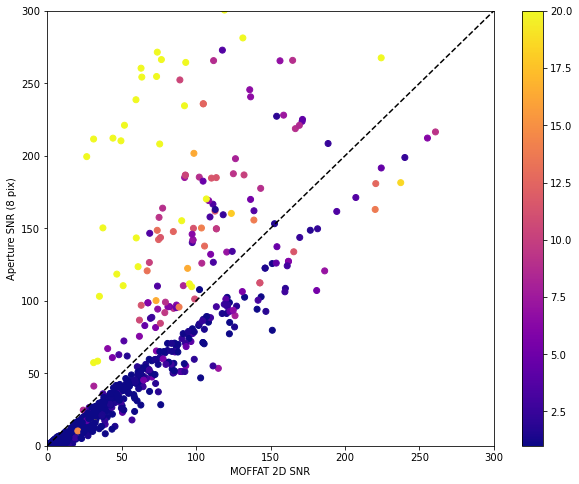

In [117]:
plt.figure(figsize=(10,8))
plt.scatter(mastercat['25um_Flux_G2D']/mastercat['25um_Flux_err_G2D'],mastercat['25um_SNR_8pix'],c=mastercat['25um_M2D_chi2'], cmap='plasma',vmin=1,vmax=20)
plt.colorbar()
plt.plot([0,300],[0,300],'k--')
plt.xlabel('MOFFAT 2D SNR')
plt.ylabel('Aperture SNR (8 pix)')
plt.xlim(0,300)
plt.ylim(0,300)

In [96]:
checksources=mastercat['25um_SNR_8pix']/(mastercat['25um_Flux_G2D']/mastercat['25um_Flux_err_G2D'])>1.0

In [97]:
cs=mastercat[checksources]

In [98]:
makeDS9reg('checksources.reg',cs,r,label='25um_SNR_4pix');

In [99]:
#checks on table quantities

In [100]:
bestsources=np.logical_and(mastercat['25ApPhot_qflag']==0,mastercat['37ApPhot_qflag']==0)
mastercat[bestsources]

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC359.348-0.082,266.09495036354866,-29.53536811998432,1.871,0.1084,17.26,4.543,0.1906,23.83,6.375,0.291,21.9,2.428,6.375,5.172,0.1808,0.3988,--,--,--,M,2.126E-38,1,0,0,0.001117 .. 0.007079,4.119,0.2118,19.45,9.406,0.3866,24.33,12.12,0.5128,23.63,2.284,1.288,8.351,0.3089,0.2529,8.352,0.3086,0.2477,M,10.87,1.138,0,0,-0.02684 .. 0.01578,"266.09495036354866,-29.53536811998432",0,0.0,0.0,0.0,0,0.0,0.0,0.0,1
SFGC359.365-0.074,266.0976520367033,-29.5169558758474,1.772,0.0947,18.71,4.237,0.1561,27.15,5.377,0.2251,23.89,2.391,5.377,4.668,0.1425,0.346,4.611,0.1403,0.324,M,9.155,1.26,0,0,0.01011 .. -0.002261,4.36,0.2048,21.29,8.482,0.3744,22.66,8.995,0.4963,18.12,1.946,1.06,7.781,0.2845,0.3834,7.743,0.2793,0.3112,M,10.84,1.493,0,0,0.01056 .. 0.01029,"266.0976520367033,-29.5169558758474",0,0.0,0.0,0.0,0,0.0,0.0,0.0,2
SFGC359.372-0.079,266.1066587461282,-29.513297870753597,3.601,0.09096,39.59,9.078,0.1523,59.59,12.87,0.2198,58.54,2.521,12.87,10.49,0.1474,1.568,10.24,0.1404,0.7087,A,6.733,1.813,0,0,0.005548 .. 0.00861,7.148,0.2026,35.28,16.2,0.3728,43.46,20.03,0.4942,40.53,2.267,1.236,14.14,0.2989,0.7741,14.02,0.2917,0.5219,M,8.066,1.626,0,0,-0.001289 .. -0.00303,"266.1066587461282,-29.513297870753597",0,0.0,0.0,0.0,0,0.0,0.0,0.0,3
SFGC359.374-0.088,266.11699223318425,-29.51585973844053,1.869,0.09748,19.17,5.283,0.1552,34.04,7.79,0.2229,34.95,2.827,7.79,6.067,0.1505,0.4887,6.061,0.1493,0.4077,M,11.8,1.359,0,0,0.01787 .. -0.0138,6.031,0.2032,29.69,13.13,0.3713,35.35,16.02,0.4918,32.58,2.176,1.221,11.7,0.3006,0.5158,11.69,0.2966,0.3798,M,12.91,1.51,0,0,0.01259 .. -0.02276,"266.11699223318425,-29.51585973844053",0,0.0,0.0,0.0,0,0.0,0.0,0.0,4
SFGC359.376-0.094,266.12312364597364,-29.517588948087333,1.619,0.1,16.18,4.446,0.1581,28.11,6.653,0.2267,29.35,2.746,6.653,5.393,0.1514,0.9055,5.466,0.1453,0.3945,G,6.851,2.766,0,0,0.002939 .. 0.002277,4.579,0.202,22.67,10.5,0.3687,28.47,13.04,0.4883,26.7,2.292,1.242,9.047,0.2957,0.7499,9.065,0.2779,0.3056,M,6.706,4.084,0,1,-0.01079 .. 0.00555,"266.12312364597364,-29.517588948087333",0,0.0,0.0,0.0,0,0.0,0.0,0.0,5
SFGC359.408-0.024,266.0744999820003,-29.45337395736227,8.204,0.8111,10.11,15.79,1.621,9.742,18.61,2.431,7.657,1.925,18.61,16.99,1.39,0.01255,16.12,1.32,0.01325,A,5.585,1.241,0,0,-7.734E-05 .. -0.0007088,18.34,1.476,12.43,34.94,2.817,12.4,40.21,3.756,10.71,1.905,1.151,31.71,2.152,0.02075,31.52,2.133,0.01604,A,7.777,1.223,0,0,0.003928 .. -0.006673,"266.0744999820003,-29.45337395736227",0,0.0,0.0,0.0,0,0.0,0.0,0.0,9
SFGC359.410+0.032,266.02006908793686,-29.42252156100146,2.435,0.7414,3.284,6.285,1.479,4.248,9.391,2.227,4.217,2.581,9

In [101]:
poor25=mastercat['25ApPhot_qflag']==111
badsources=mastercat[poor25]
makeDS9reg('sources_25_photflag_111.reg',badsources,r,label='id');
len(badsources)

104

In [102]:
poor37=mastercat['37ApPhot_qflag']==111
badsources=mastercat[poor37]
makeDS9reg('sources_37_photflag_111.reg',badsources,r,label='id');
len(badsources)

103

In [103]:
#poor=np.logical_and(mastercat['25phot_qflag']>1,mastercat['37phot_qflag']>1)
#badsources=mastercat[poor]

In [104]:
#makeDS9reg('photflagsources.reg',badsources,r);

In [105]:
#check for negative source fluxes - replace if found or just flag?
ts=mastercat[mastercat['25um_Flux_4pix']<0]
makeDS9reg('problemsources25_4pix.reg',ts,r,color='red');
ts

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC359.908-0.007,266.3563708470723,-29.018393257955392,-0.02279,3.311,-0.006885,-0.2953,0.5483,-0.5386,-0.5818,0.4819,-1.207,12.96,1.97,0.05866,0.04252,0.3854,0.07957,0.04767,0.3823,M,2.994,2.879,--,--,-- .. --,0.6394,0.3596,1.778,1.305,0.5261,2.48,1.123,0.7216,1.556,2.041,0.8606,1.214,0.2798,0.2464,1.142,0.2421,0.2302,M,15.02,5.16,0,1,-0.005238 .. 0.03059,"266.3563708470723,-29.018393257955392",111,9.909843614304869,1.3495733938562884,0.8639856851059335,111,1.718149350967987,2.882984441175667,3.2875696377815427,688
SFGC359.926-0.047,266.4070516747887,-29.02373968386626,-0.1132,4.804,-0.02357,-0.3605,3.02,-0.1193,2.311,0.7354,3.142,3.184,-6.411,-2.874,0.1945,4.213,-3.12,0.1981,3.984,A,15.14,2.54,--,--,-- .. --,8.425,0.3172,26.56,28.82,0.3735,77.15,54.33,0.4714,115.3,3.42,1.885,24.86,0.4365,3.339,24.69,0.2328,1.876,G,174.9,18.62,0,21,-0.005861 .. 0.3051,"266.4070516747887,-29.02373968386626",110,14.297945931496855,8.70030113898434,0.0,0,0.0,0.0,0.0,693
SFGC0.664-0.039,266.83589105284943,-28.38845008793058,-0.2047,0.3345,-0.612,0.9398,0.3997,2.351,--,--,--,-4.591,--,--,--,--,--,--,--,A,2.126E-38,1,--,--,-- .. --,14.5,0.3489,41.56,66.67,0.7857,84.85,--,--,--,4.598,--,47.89,0.6868,0.4962,--,--,--,M,2.126E-38,1,0,21,0.01354 .. --,"266.83589105284943,-28.38845008793058",110,0.7987566913209971,2.138997185406325,0.0,0,0.0,0.0,0.0,869


In [106]:
ts=mastercat[mastercat['25um_Flux_8pix']<0]
makeDS9reg('problemsources25_8pix.reg',ts,r,color='magenta');
ts

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC359.434-0.078,266.1424582586157,-29.45998416557863,0.3374,0.2003,1.685,-0.07595,1.588,-0.04782,-0.5965,0.379,-1.574,-0.2251,7.854,0.3823,0.05531,0.2851,0.3863,0.05512,0.2805,M,2.364,1.353,0,0,-0.001477 .. 0.0007534,2.418,0.3519,6.871,7.381,0.4177,17.67,14.33,0.5152,27.81,3.052,1.941,5.892,0.263,0.527,--,--,--,M,2.126E-38,1,--,--,-- .. --,"266.1424582586157,-29.45998416557863",111,0.9381928466792295,4.689166565245717,0.5403787420000478,0,0.0,0.0,0.0,406
SFGC0.083-0.106,266.55714302499206,-28.92054823717264,0.2898,0.2349,1.234,-0.02211,5.607,-0.003942,-0.1927,0.9971,-0.1933,-0.07627,8.719,0.3339,0.06949,0.4394,0.3533,0.07235,0.4365,M,2.367,1.817,0,0,0.02049 .. 0.006246,0.9233,0.3414,2.704,2.091,0.5205,4.018,2.612,0.6676,3.912,2.265,1.249,1.712,0.3213,0.2849,1.836,0.3259,0.2725,M,5.048,2.715,--,--,-- .. --,"266.55714302499206,-28.92054823717264",111,0.9945621798419444,16.79966721942059,2.7985463907810573,100,1.9474092986556073,0.0,0.0,527
SFGC0.163-0.042,266.5424567899163,-28.819016392090024,0.6703,0.9844,0.6809,-0.9637,1.372,-0.7025,1.333,1.494,0.8922,-1.438,-1.384,0.7725,0.167,8.133,1.916,0.1634,5.881,A,3.834,11.38,0,0,0.1218 .. -0.0005469,7.34,0.3626,20.24,22.96,0.412,55.72,42.33,0.5146,82.26,3.127,1.844,18.18,0.2606,1.287,18.23,0.2608,1.222,M,12.8,1.406,--,--,-- .. --,"266.5424567899163,-28.819016392090024",111,3.6234448331928273,3.1518536827823365,5.8166211486967585,0,0.0,0.0,0.0,574
SFGC359.908-0.007,266.3563708470723,-29.018393257955392,-0.02279,3.311,-0.006885,-0.2953,0.5483,-0.5386,-0.5818,0.4819,-1.207,12.96,1.97,0.05866,0.04252,0.3854,0.07957,0.04767,0.3823,M,2.994,2.879,--,--,-- .. --,0.6394,0.3596,1.778,1.305,0.5261,2.48,1.123,0.7216,1.556,2.041,0.8606,1.214,0.2798,0.2464,1.142,0.2421,0.2302,M,15.02,5.16,0,1,-0.005238 .. 0.03059,"266.3563708470723,-29.018393257955392",111,9.909843614304869,1.3495733938562884,0.8639856851059335,111,1.718149350967987,2.882984441175667,3.2875696377815427,688
SFGC359.926-0.047,266.4070516747887,-29.02373968386626,-0.1132,4.804,-0.02357,-0.3605,3.02,-0.1193,2.311,0.7354,3.142,3.184,-6.411,-2.874,0.1945,4.213,-3.12,0.1981,3.984,A,15.14,2.54,--,--,-- .. --,8.425,0.3172,26.56,28.82,0.3735,77.15,54.33,0.4714,115.3,3.42,1.885,24.86,0.4365,3.339,24.69,0.2328,1.876,G,174.9,18.62,0,21,-0.005861 .. 0.3051,"266.4070516747887,-29.02373968386626",110,14.297945931496855,8.70030113898434,0.0,0,0.0,0.0,0.0,693
SFGC0.016+0.006,266.40892798207443,-28.919413154260667,0.03519,2.147,0.01639,-0.2389,0.6593,-0.3623,-1.03,0.3524,-2.923,-6.79,4.312,0.05575,0.02177,0.4891,0.09014,0.03308,0.4859,M,0.473,8.639,--,--,-- .. --,1.688,0.27,6.252,1.3

In [107]:
ts=mastercat[mastercat['25um_Flux_12pix']<0]
makeDS9reg('problemsources25_12pix.reg',ts,r,color='yellow');
ts

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC0.153-0.036,266.530548636114,-28.82410395378865,1.022,0.335,3.052,0.548,1.217,0.4505,-1.1,0.9256,-1.189,0.5361,-1.1,2.306,0.1689,5.011,2.526,0.1705,4.685,A,4.208,2.549,0,20,0.05489 .. 0.03052,2.282,0.5057,4.513,3.207,0.7306,4.389,5.504,0.6904,7.973,1.405,1.716,5.923,0.2712,2.514,6.117,0.272,2.422,A,5.275,1.596,0,20,-0.00804 .. 0.009049,"266.530548636114,-28.82410395378865",11,0.0,4.1978488137732715,1.6763355766598809,0,0.0,0.0,0.0,245
SFGC0.180-0.098,266.6078134,-28.8334936,0.461,0.1866,2.47,0.1379,1.051,0.1312,-0.3299,0.7017,-0.4701,0.2992,-0.3299,0.4622,0.05271,0.3686,0.4447,0.05061,0.3671,M,2.389,1.257,0,0,-0.01844 .. -0.005646,0.8058,0.3375,2.387,0.773,0.6533,1.183,1.537,0.7119,2.159,0.9592,1.989,0.8362,0.1526,0.1812,0.826,0.1501,0.1802,M,2.839,1.2,0,0,0.0009319 .. 0.02235,"266.6078134,-28.8334936",111,1.0209125539100767,3.2920919373835185,1.775231881336747,111,1.8183978146072415,2.7329111212906247,3.6726461554388248,277
SFGC359.434-0.078,266.1424582586157,-29.45998416557863,0.3374,0.2003,1.685,-0.07595,1.588,-0.04782,-0.5965,0.379,-1.574,-0.2251,7.854,0.3823,0.05531,0.2851,0.3863,0.05512,0.2805,M,2.364,1.353,0,0,-0.001477 .. 0.0007534,2.418,0.3519,6.871,7.381,0.4177,17.67,14.33,0.5152,27.81,3.052,1.941,5.892,0.263,0.527,--,--,--,M,2.126E-38,1,--,--,-- .. --,"266.1424582586157,-29.45998416557863",111,0.9381928466792295,4.689166565245717,0.5403787420000478,0,0.0,0.0,0.0,406
SFGC359.757+0.005,266.2553826,-29.1412836,0.8143,0.1571,5.183,0.8596,0.3001,2.865,-0.009973,28.53,-0.0003495,1.056,-0.0116,0.9815,0.08897,0.4362,0.9953,0.09003,0.4368,M,4.01,1.157,0,0,-0.001631 .. -0.03858,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,A,2.126E-38,1,--,--,-- .. --,"266.2553826,-29.1412836",11,0.0,1.7597366402373564,85.5920795353605,0,0.0,0.0,0.0,436
SFGC359.955-0.031,266.4079814372357,-28.991032760887705,0.9622,0.2435,3.952,0.7,0.6297,1.112,-0.5095,1.267,-0.4021,0.7275,-0.7279,1.09,0.08909,1.208,1.407,0.1026,1.078,M,2.608,2.645,0,0,-0.000539 .. 0.02626,0.1948,5.423,0.03593,-3.454,0.7482,-4.616,-5.1,0.8068,-6.321,-17.73,1.477,2.194,0.3434,2.209,2.044,0.3075,2.186,A,3.73,2.552,--,--,-- .. --,"266.4079814372357,-28.991032760887705",11,0.0,2.589048422011248,3.2920971661456817,111,16.46261294851205,-1.2089925473958991,-2.67908817786509,478
SFGC359.958-0.029,266.40825013578797,-28.987411936338404,1.285,0.2583,4.975,0.9765,0.6472,1.509,-0.1366,6.636,-0.02058,0.7599,-0.1398,1.711,0.1139,1.307,1.863,0.1095,1.086,M,2.919,2.321,0,0,0.01991 .. 0.05987,1.484,0.8239,1.801,-0.7409,3.032,-0.2444,0.3494,8.488,0.04116,-0.4993,-0.4716,-2.338,0.2324,0.8063,--,--,--,M,2.126E-38,1,--,-

In [108]:
mastercat[mastercat['37um_Flux_5.5pix']<0]

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC359.925+0.015,266.34523206946267,-28.992391637679,0.7013,0.1118,6.273,0.7816,0.1921,4.068,0.3909,0.4432,0.8819,1.114,0.5001,0.8712,0.06056,0.5004,0.9216,0.06119,0.4313,M,2.559,1.894,0,0,-0.004446 .. 0.004471,-0.255,0.6391,-0.399,-1.459,0.3916,-3.725,-2.284,0.4755,-4.804,5.721,1.566,-1.322,0.2285,0.3354,0.1021,0.05537,0.4399,M,2.966,3.26,--,--,-- .. --,"266.34523206946267,-28.992391637679",1,0.0,0.0,1.7205451556662923,111,1.6622875636719443,-0.28397214293291584,-0.8578747048041746,448
SFGC359.941-0.047,266.41591289251033,-29.011575486381314,17.37,0.3632,47.84,63.27,0.2429,260.5,320.5,0.2189,1464,3.641,5.065,104.9,1.782,640.6,104.6,1.66,565.2,A,25.16,2.746,3,20,0.3456 .. 0.3532,-39.45,0.4696,-84.02,-62.23,0.6252,-99.54,82.34,0.6991,117.8,1.577,-1.323,-109.5,8.413,1419,-118.7,8.149,1296,A,7.809,41.99,--,--,-- .. --,"266.41591289251033,-29.011575486381314",0,0.0,0.0,0.0,110,-38.04435724544018,-60.3573874242129,0.0,462
SFGC359.967+0.002,266.38294793306153,-28.9632480244344,0.7753,0.131,5.919,0.6562,0.2722,2.41,0.2837,0.7977,0.3557,0.8464,0.4323,0.9103,0.07386,0.5618,0.8843,0.07132,0.5553,M,3.882,1.213,0,0,0.008121 .. 0.0184,-1.157,0.321,-3.604,-2.887,0.4519,-6.388,-4.361,0.5777,-7.549,2.495,1.511,-3.051,0.2679,0.3699,-3.014,0.258,0.347,M,15.13,2.317,--,--,-- .. --,"266.38294793306153,-28.9632480244344",11,0.0,1.4729950870014603,2.6767681110776405,111,-0.19382967054603428,-1.5313153158836204,-2.6282906832362585,489
SFGC359.980+0.018,266.37576546485667,-28.94422162038458,1.007,0.2437,4.131,1.295,0.439,2.951,1.733,0.6181,2.804,1.287,1.338,1.087,0.141,0.3053,1.042,0.1352,0.3053,M,2.716,1.044,0,0,-0.02071 .. -0.02802,-0.04602,20.5,-0.002244,0.5003,3.683,0.1359,3.045,1.302,2.339,-10.87,6.085,2.641,0.3799,0.4144,2.726,0.3781,0.4016,M,5.932,14.15,--,--,-- .. --,"266.37576546485667,-28.94422162038458",11,0.0,2.6122303712044057,3.587408960328916,111,61.468772017357864,11.548645442623192,6.950282202915266,491
SFGC359.986-0.061,266.45572062611586,-28.980151187658542,1.46,0.09451,15.45,1.564,0.1618,9.668,0.909,0.2757,3.297,1.071,0.5813,1.723,0.06751,0.5161,1.734,0.06676,0.4343,M,2.991,1.479,0,0,-0.01152 .. 0.007233,-1.353,0.2272,-5.955,-7.083,0.3577,-19.8,-10.94,0.4721,-23.17,5.235,1.544,-5.739,0.2909,0.4549,0.07431,0.05435,1.8,M,2.465,2.666,--,--,-- .. --,"266.45572062611586,-28.980151187658542",0,0.0,0.0,0.0,111,-0.6714719537547458,-6.010102272361415,-9.52010977186777,495
SFGC0.040-0.056,266.48366246515945,-28.931265520024056,0.791,0.1146,6.9,1.053,0.1845,5.705,1.309,0.2508,5.219,1.331,1.244,1.048,0.0773,0.4202,1.037,0.07355,0.369,M,3.049,1.735,0,0,0.003413 .. -0.005908,-0

In [109]:
mastercat[mastercat['37um_Flux_10.5pix']<0]

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC0.014-0.046,266.4583205912805,-28.947678772774754,1.747,0.09552,18.29,2.121,0.1626,13.04,2.081,0.2365,8.798,1.214,2.081,2.227,0.07779,0.6823,2.118,0.07104,0.4462,M,4.862,1.792,0,0,0.001298 .. -0.003853,0.7065,0.2967,2.381,-0.5026,0.6845,-0.7342,-1.924,0.5503,-3.497,-0.7114,3.829,0.7783,0.1164,0.3012,0.8053,0.1181,0.2951,M,2.411,1.54,0,0,-0.01804 .. -0.005747,"266.4583205912805,-28.947678772774754",0,0.0,0.0,0.0,111,1.5966445861234584,1.5508672080425177,-0.2737256639713994,164
SFGC0.108-0.016,266.4843717331022,-28.852471503655984,2.587,0.09466,27.33,3.927,0.1588,24.73,3.895,0.2304,16.91,1.518,3.895,4.017,0.0982,0.6057,3.894,0.09441,0.5086,M,4.216,1.326,0,0,0.01258 .. 0.003512,0.6777,0.3391,1.999,-1.197,0.4864,-2.461,-1.337,0.6239,-2.143,-1.766,1.117,1.143,0.1285,0.6703,1.331,0.1429,0.6435,M,2.688,1.774,0,0,0.0189 .. -0.0006766,"266.4843717331022,-28.852471503655984",0,0.0,0.0,0.0,111,1.6950252867447284,0.26222679859308995,0.5349415406104152,215
SFGC359.514-0.074,266.1866903832937,-29.389531429816437,0.5133,0.7759,0.6616,0.6309,1.546,0.4081,0.4988,2.324,0.2146,1.229,0.7906,0.5761,0.6225,0.002776,0.6034,0.636,0.002624,M,2.44,1.575,0,0,0.001979 .. -0.002355,0.4902,1.419,0.3454,-0.06336,4.615,-0.01373,-0.644,3.714,-0.1734,-0.1293,10.16,0.5344,1.022,0.003178,0.5255,0.9943,0.003157,M,4.282,1.4,--,--,-- .. --,"266.1866903832937,-29.389531429816437",111,2.840837819992072,5.268818421200523,7.471747115008114,111,4.74772413522493,13.782338587837158,10.49830571201193,415
SFGC359.742+0.006,266.2447233332759,-29.152908292488075,0.6393,0.1133,5.64,0.5774,0.2189,2.638,0.4055,0.4139,0.9796,0.9033,0.7022,0.6769,0.05103,0.2758,0.6756,0.05069,0.2698,M,3.328,1.256,0,0,-0.000721 .. 0.009138,0.2803,0.4552,0.6157,-0.1201,1.874,-0.06408,-0.1985,1.557,-0.1275,-0.4284,1.653,0.3814,0.09282,0.2499,0.3796,0.0912,0.2484,M,2.049,1.533,--,--,-- .. --,"266.2447233332759,-29.152908292488075",11,0.0,1.2340513083079903,1.647296694075219,111,1.6460326145924284,5.501617798522257,4.472373505954294,431
SFGC359.925+0.015,266.34523206946267,-28.992391637679,0.7013,0.1118,6.273,0.7816,0.1921,4.068,0.3909,0.4432,0.8819,1.114,0.5001,0.8712,0.06056,0.5004,0.9216,0.06119,0.4313,M,2.559,1.894,0,0,-0.004446 .. 0.004471,-0.255,0.6391,-0.399,-1.459,0.3916,-3.725,-2.284,0.4755,-4.804,5.721,1.566,-1.322,0.2285,0.3354,0.1021,0.05537,0.4399,M,2.966,3.26,--,--,-- .. --,"266.34523206946267,-28.992391637679",1,0.0,0.0,1.7205451556662923,111,1.6622875636719443,-0.28397214293291584,-0.8578747048041746,448
SFGC359.941-0.047,266.41591289251033,-29.011575486381314,17.37,0.3632,47.84,63.27,0.2429,260.5,320.5,0.2189,1464,3

In [110]:
ts2=mastercat[mastercat['37um_Flux_14pix']<0]
ts2

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC359.442-0.102,266.1714345711507,-29.465688697659726,1.154,0.1075,10.73,0.9538,0.207,4.607,0.3093,0.6511,0.475,0.8267,0.3093,1.25,0.06521,0.4262,1.272,0.06615,0.4188,M,3.016,1.166,0,0,0.006017 .. 0.006715,2.759,0.2084,13.24,0.9444,0.5269,1.792,-1.94,0.5424,-3.576,0.3422,-2.054,2.904,0.1258,0.5135,2.986,0.1281,0.4755,M,3.948,1.301,0,0,0.00875 .. 0.008957,"266.1714345711507,-29.465688697659726",1,0.0,0.0,2.2627109114322876,11,0.0,2.524943473010413,-0.3125550226231548,31
SFGC0.014-0.046,266.4583205912805,-28.947678772774754,1.747,0.09552,18.29,2.121,0.1626,13.04,2.081,0.2365,8.798,1.214,2.081,2.227,0.07779,0.6823,2.118,0.07104,0.4462,M,4.862,1.792,0,0,0.001298 .. -0.003853,0.7065,0.2967,2.381,-0.5026,0.6845,-0.7342,-1.924,0.5503,-3.497,-0.7114,3.829,0.7783,0.1164,0.3012,0.8053,0.1181,0.2951,M,2.411,1.54,0,0,-0.01804 .. -0.005747,"266.4583205912805,-28.947678772774754",0,0.0,0.0,0.0,111,1.5966445861234584,1.5508672080425177,-0.2737256639713994,164
SFGC0.108-0.016,266.4843717331022,-28.852471503655984,2.587,0.09466,27.33,3.927,0.1588,24.73,3.895,0.2304,16.91,1.518,3.895,4.017,0.0982,0.6057,3.894,0.09441,0.5086,M,4.216,1.326,0,0,0.01258 .. 0.003512,0.6777,0.3391,1.999,-1.197,0.4864,-2.461,-1.337,0.6239,-2.143,-1.766,1.117,1.143,0.1285,0.6703,1.331,0.1429,0.6435,M,2.688,1.774,0,0,0.0189 .. -0.0006766,"266.4843717331022,-28.852471503655984",0,0.0,0.0,0.0,111,1.6950252867447284,0.26222679859308995,0.5349415406104152,215
SFGC0.190+0.036,266.48263315590583,-28.75525978718012,2.426,0.09355,25.94,3.115,0.1576,19.76,2.354,0.2355,9.994,1.284,2.354,3.147,0.07892,0.5339,2.971,0.07379,0.428,M,3.309,1.365,0,0,0.0007985 .. 0.00327,1.646,0.2374,6.934,0.5704,0.697,0.8183,-1.017,0.6791,-1.498,0.3465,-1.783,1.742,0.1623,0.2806,1.792,0.1612,0.2521,M,5.092,1.623,0,0,0.01536 .. 0.0181,"266.48263315590583,-28.75525978718012",0,0.0,0.0,0.0,11,0.0,2.661382387463872,1.0200466719960555,294
SFGC359.514-0.074,266.1866903832937,-29.389531429816437,0.5133,0.7759,0.6616,0.6309,1.546,0.4081,0.4988,2.324,0.2146,1.229,0.7906,0.5761,0.6225,0.002776,0.6034,0.636,0.002624,M,2.44,1.575,0,0,0.001979 .. -0.002355,0.4902,1.419,0.3454,-0.06336,4.615,-0.01373,-0.644,3.714,-0.1734,-0.1293,10.16,0.5344,1.022,0.003178,0.5255,0.9943,0.003157,M,4.282,1.4,--,--,-- .. --,"266.1866903832937,-29.389531429816437",111,2.840837819992072,5.268818421200523,7.471747115008114,111,4.74772413522493,13.782338587837158,10.49830571201193,415
SFGC359.620-0.049,266.2259614210343,-29.286371355804484,0.5514,0.1755,3.142,1.179,0.2333,5.051,1.81,0.31,5.839,2.138,1.536,1.442,0.1825,0.5714,1.639,0.1801,0.48,M,44.8,8.995,0,0,-0.009453 

In [111]:
#makeDS9reg('problemsources37.reg',ts2,r,label='37um_Flux_14pix');

In [112]:
makeDS9reg('ExamineErrors.reg',mastercat,r,label='25um_Flux_err_8pix');

## Optional - Create combined Segment Map Catalogs (mainly for testing purposes)

In [113]:
#create combined field segment map source catalog at 25 um
Segcat25=CombineFieldResults('segCat',25)

#Remove duplications from overlapping fields
SegCat25=remove_duplicates(Segcat25, 3.0*u.arcsec)

#lets examine SNR cuts...
snrcut4pix=SegCat25['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
Segcat25snr=SegCat25[snrcut4pix] #apply snr cut
print("Number of 25 um Seg Catalog Sources after SNR cut: ", len(Segcat25snr))

#write ds9 file
makeDS9file('Segcat_4pixSNRselect_25m_NoLabel.reg', Segcat25snr, r, color='green')

#write fits file
Segcat25snr.write('SegCat_CombinedFields_snrcut.fits',overwrite=True)

Error... Must pick another file to start with


UnboundLocalError: local variable 'cat' referenced before assignment

In [ ]:
Segcat25snr

In [ ]:
#create combined field segment map source catalog at 37 um
Segcat37=CombineFieldResults('segCat',37)

#Remove duplications from overlapping fields
SegCat37=remove_duplicates(Segcat37, 3.0*u.arcsec)

#lets examine SNR cuts...
snrcut4pix=SegCat37['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
Segcat37snr=SegCat37[snrcut4pix] #apply snr cut
print("Number of 37 um Seg Catalog Sources after SNR cut: ", len(Segcat37snr))

#write ds9 file
makeDS9file('Segcat_4pixSNRselect_37m_NoLabel.reg', Segcat37snr, r, color='green')

#write fits file
Segcat37snr.write('SegCat_CombinedFields_snrcut.fits',overwrite=True)

In [ ]:
Segcat37snr